In [1]:
from transformers import pipeline
import torch
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.stats import norm
from statistics import mean, variance as var



model = AutoModelForCausalLM.from_pretrained("gpt2", output_attentions=True, output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# Set pad token (GPT-2 doesn't have one by default)
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id
model.eval()

X_static = model.get_input_embeddings().weight.detach().cpu().numpy()
vocab = [tokenizer.decode([i]) for i in range(len(tokenizer))]

C:\Users\lucaf\anaconda3\ancaonda_3\Lib\site-packages\transformers\generation\configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(
C:\Users\lucaf\anaconda3\ancaonda_3\Lib\site-packages\transformers\generation\configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


In [2]:

def inp(prompt):

    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"]


    with torch.no_grad():
        output = model(input_ids, use_cache=True, output_hidden_states=True)

    key_values = output.past_key_values # (batch, heads, sequence, head_dim)
    hidden_states = output.hidden_states

    return hidden_states
    
# Make sure these globals are initialized once outside the function:
embedding_outputs = []  
attention_outputs = []
mlp_outputs = []
ln1_outputs = []  #before attention
ln2_outputs = []  #after attention

def embedding(prompt):
    global embedding_outputs, attention_outputs, mlp_outputs, ln1_outputs, ln2_outputs

    # Clear lists BEFORE forward pass
    embedding_outputs.clear()
    attention_outputs.clear()
    mlp_outputs.clear()
    ln1_outputs.clear()
    ln2_outputs.clear()

    handles = []  # to store hook handles

    def get_embedding_output(module, input, output):
        embedding_outputs.append(output.detach())

    def get_attention_output(module, input, output):
        attention_outputs.append(output[0].detach())

    def get_mlp_output(module, input, output):
        mlp_outputs.append(output.detach())

    def get_ln1_output(module, input, output):
        ln1_outputs.append(output.detach())

    def get_ln2_output(module, input, output):
        ln2_outputs.append(output.detach())

    inputs = tokenizer(prompt, return_tensors="pt")

    # Register hooks and save handles
    handles.append(model.transformer.drop.register_forward_hook(get_embedding_output))

    for block in model.transformer.h:
        handles.append(block.ln_1.register_forward_hook(get_ln1_output))
        handles.append(block.attn.register_forward_hook(get_attention_output))
        handles.append(block.ln_2.register_forward_hook(get_ln2_output))
        handles.append(block.mlp.register_forward_hook(get_mlp_output))

    handles.append(model.transformer.ln_f.register_forward_hook(get_ln1_output))

    # Forward pass
    with torch.no_grad():
        _ = model(**inputs)

    
    # Remove hooks immediately after forward pass
    for handle in handles:
        handle.remove()

    # Return ln1_outputs collected during the forward pass
    return ln1_outputs





In [3]:
def Gram(H_0, H_1, plot_gram):
   
    H_0 = H_0 - H_0.mean(dim=0, keepdim=True)
    H_1 = H_1 - H_1.mean(dim=0, keepdim=True)
    
    gram_matrix = H_0 @ H_1.T
    
#    mean = torch.mean(G, dim=0, keepdim=True)
#    gram_matrix = ( G - mean) #/(G.shape[0]-1)
    
    if plot_gram:
        
        mask = np.zeros_like(gram_matrix.cpu().numpy(), dtype=bool)
        mask[:, 0] = True
        mask[0, :] = True
        
        sns.heatmap(Gram_matrix, cmap="viridis", mask=mask, vmin=-1000, vmax=1000)
        plt.title(f"Layer {layer} Gram Matrix")
        plt.show()
    
    return gram_matrix


def Gram_2(H_0, H_1):
   
    H_0 = H_0 - H_0.mean(dim=0, keepdim=True)
    H_1 = H_1 - H_1.mean(dim=0, keepdim=True)
    
    gram_matrix = H_0.T @ H_1

    return gram_matrix 
    
def principle_angle(G):

        _, S, _ = torch.linalg.svd(G)
        angles = torch.rad2deg(torch.arccos(torch.clamp(S, -1.0, 1.0)))
    
        return (angles,S)



In [4]:
def analyze_layer_svd_mp(activations, layer_indices=None, cumulative_threshold=0.9, title_prefix="LN1"):
    """
    Perform SVD, plot scree + cumulative variance, and compare to Marčenko–Pastur bounds for selected layers.
    
    Args:
        activations (List[Tensor]): List of layer outputs, one per layer.
        layer_indices (List[int]): Indices of layers to analyze. If None, analyze all.
        cumulative_threshold (float): Threshold for cumulative explained variance line.
        title_prefix (str): For plot titles.
    """
    if layer_indices is None:
        layer_indices = range(len(activations))

    n = len(layer_indices)
    fig, axes = plt.subplots(n, 3, figsize=(16, 4 * n), squeeze=False)

    for i, layer_idx in enumerate(layer_indices):
        X = activations[layer_idx][0].cpu().numpy()  # shape: [seq_len, hidden_dim]
        X_centered = X - X.mean(axis=0)
        U, S, VT = np.linalg.svd(X_centered, full_matrices=False)
        
        # Explained variance
        eigenvalues = (S ** 2) / X.shape[0]
        variance_ratios = eigenvalues / eigenvalues.sum()
        cumulative = np.cumsum(variance_ratios)

        # MP bounds
        n_samples, n_features = X.shape
        Q = n_samples / n_features
        sigma2 = np.var(X_centered)
        lambda_min = sigma2 * (1 - np.sqrt(1/Q))**2
        lambda_max = sigma2 * (1 + np.sqrt(1/Q))**2
        signal_count = np.sum(eigenvalues > lambda_max)

        # Scree plot
        ax1 = axes[i][0]
        ax1.plot(variance_ratios, marker='o')
        ax1.set_title(f"{title_prefix} Layer {layer_idx} - Scree")
        ax1.set_xlabel("PC Index")
        ax1.set_ylabel("Variance Ratio")
        ax1.grid(True)

        # Cumulative plot
        ax2 = axes[i][1]
        ax2.plot(cumulative, marker='o', color='green')
        ax2.axhline(y=cumulative_threshold, color='r', linestyle='--', label=f'{int(cumulative_threshold*100)}% threshold')
        ax2.set_title(f"{title_prefix} Layer {layer_idx} - Cumulative")
        ax2.set_xlabel("PC Index")
        ax2.set_ylabel("Cumulative Variance")
        ax2.set_ylim([0, 1.05])
        ax2.grid(True)
        ax2.legend()

        # Eigenvalue vs MP bounds
        ax3 = axes[i][2]
        ax3.plot(eigenvalues, marker='o', label="Eigenvalues")
        ax3.axhline(lambda_max, color='r', linestyle='--', label=f'MP Upper: {lambda_max:.4f}')
        ax3.axhline(lambda_min, color='gray', linestyle='--', label=f'MP Lower: {lambda_min:.4f}')
        ax3.set_title(f"{title_prefix} Layer {layer_idx} - MP Test\nSignal dims: {signal_count}")
        ax3.set_xlabel("Index")
        ax3.set_ylabel("Eigenvalue")
        ax3.grid(True)
        ax3.legend()

    plt.tight_layout()
    plt.show()



In [17]:


def Q_work(Q):
    Q = np.asarray(Q)
    mu = np.mean(Q)
    sigma = np.std(Q)


    n = 1
    # Define bounds
    lower_bound = mu - n * sigma
    upper_bound = mu + n * sigma

    # Find values more than 2 sigma away
    outliers = Q[(Q < lower_bound) | (Q > upper_bound)]

    # Plot histogram of all data
    plt.hist(Q, bins=20, density=True, color='skyblue', alpha=0.7, label='Data')

    # Plot Gaussian fit
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
    y = norm.pdf(x, mu, sigma)
    plt.plot(x, y, 'r-', label='Gaussian PDF')

    # Overlay outliers
    if len(outliers) > 0:
        plt.hist(outliers, bins=20, density=True, color='orange', alpha=0.8, label='> 2σ')

    # Labels and legend
    plt.title('Normal Distribution Fit')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

def first_prompt(dimension, Q_arr_list, eigenvalues_list):
    """
    Plots eigenvalues and Q values for each layer in separate plots.
    `dimension` is assumed to be constant across layers.
    `Q_arr_list` and `eigenvalues_list` are lists of arrays (one per layer).
    """
    n_layers = len(eigenvalues_list)

    for i in range(n_layers):
        eigenvalues = eigenvalues_list[i]
        Q_arr = Q_arr_list[i]


        plt.figure(figsize=(12, 4))

        # Plot 1: Eigenvalues
        plt.subplot(1, 2, 1)
        plt.plot(np.arange(1,len(eigenvalues)+1), eigenvalues, marker='o', label=f"Layer {i}")
        plt.title(f"Eigenvalues - Layer {i}")
        plt.xlabel("Index")
        plt.ylabel("Eigenvalue")
        plt.grid(True)

        # Plot 2: Q values
        plt.subplot(1, 2, 2)
        plt.plot(np.arange(1,len(Q_arr)+1), Q_arr, marker='s', label=f"Layer {i}", color='orange')
        plt.title(f"Q values - Layer {i}")
        plt.xlabel("Index")
        plt.ylabel("Q")
        plt.grid(True)

        plt.suptitle(f"Layer {i}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


    plt.figure(figsize=(8, 5))
    x_dim = np.arange(len(dimension))
    plt.plot(x_dim, dimension, linestyle='--', color='red', marker='o', label='Dimension')

    # Annotate each point with its value
    for x, y in zip(x_dim, dimension):
        plt.text(x, y + max(dimension)*0.02, f"{y}", ha='center', fontsize=9, color='darkred')

    plt.title("Model Dimension Across Layers", fontsize=13)
    plt.xlabel("Layer Index", fontsize=11)
    plt.ylabel("Dimension", fontsize=11)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def dimension_compute(eigenvalues, X):
    Q_arr=[]
          
    for i in range(len(eigenvalues)-2):
        Q=(eigenvalues[i]-eigenvalues[i+1])/(eigenvalues[i+1]-eigenvalues[i+2])

        Q_arr.append(Q)
        
    Q_max=max(Q_arr)
    
    if Q_max>10:  #very big limit
        d = np.argmax(Q_arr) + 2
              
    else: 
        X_centered = X - X.mean(axis=0)
        n_samples, n_features = X.shape
        Q = n_samples / n_features
        sigma = torch.var(X_centered, unbiased=False).item()
        
        lambda_max = sigma * (1 + np.sqrt(1/Q))**2
        d = np.sum(eigenvalues > lambda_max)

    return(d, Q_arr)


In [18]:
def get_signal_dimensions(activations):
    """
    Returns a list of signal subspace dimensions per layer using MP bound.
    """
    signal_dims = []

    for layer_out in activations:
        X = layer_out[0].cpu().numpy()  # [seq_len, hidden_dim]
        X_centered = X - X.mean(axis=0)
        U, S, VT = np.linalg.svd(X_centered, full_matrices=False)
        eigenvalues = (S ** 2) / X.shape[0]

        n_samples, n_features = X.shape
        Q = n_samples / n_features
        sigma2 = np.var(X_centered)

        lambda_max = sigma2 * (1 + np.sqrt(1/Q))**2
        d = np.sum(eigenvalues > lambda_max)
        signal_dims.append(d)

    return signal_dims



def compute_P_angle(prompt):
    pAngle_all = []
    dist_all=[]
    rows=[]
    Q_plot=False

    for n,i in enumerate(prompt):
    
      #  hidden_states= embedding(i)  #if u want to analyze before attention mechanism
        hidden_states= inp(i)
        
        plot_gram=False
        U_list=[]
        dimension=[]
        Q_tot=[]
        eight_tot =[]


        for layer in range(len(hidden_states)):
    
            gram_matrix = Gram(hidden_states[layer][0], hidden_states[layer][0], plot_gram)

        ####################################### defining d ######################
    
            eigenvalues, _ = torch.linalg.eigh(gram_matrix)
            eigenvalues=np.sort(eigenvalues)[::-1]

            eight_tot.append(eigenvalues)

            d, Q_arr = dimension_compute(eigenvalues, hidden_states[layer][0])

            dimension.append(d)
            Q_tot.append(Q_arr)
      
            U, _, _ = torch.svd(gram_matrix)

            U_d = U[:, :d]    
            U_list.append(U_d)

            p_Angle=[]
            dist = []


        for i in range(len(U_list)):
            temp_2=[]
            temp_1=[]
            
            for j in range(len(U_list)):
    
                G_sup=Gram_2(U_list[i], U_list[j])
                angles, S= principle_angle(G_sup)        
               
                temp_2.append(angles.sum().item())
                temp_1.append(torch.norm(angles).item())

            p_Angle.append(temp_2)
            dist.append(temp_1)

        pAngle_all.append(np.array(p_Angle))
        dist_all.append(np.array(dist))

        if n==0:
           first_prompt(dimension, Q_tot, eight_tot)
           analyze_layer_svd_mp(hidden_states, layer_indices=[0, 6, 12], title_prefix="LN1")

        return(pAngle_all,  dist_all, Q_tot)
        



In [19]:
def plot_principle_angle(pAngle_all,dist_all, Q_tot):
    pAngle_all = np.stack(pAngle_all)  # (num_prompts, num_layers, num_layers)
    dist_all = np.stack(dist_all)
    heat_mean = pAngle_all.mean(axis=0)  # (num_layers, num_layers)
    heat_mean_dist = dist_all.mean(axis=0)

    # Maschera diagonale
    mask_diag = np.eye(heat_mean.shape[0], dtype=bool)

    # Heatmap angoli principali
    plt.figure(figsize=(8, 7))
    sns.heatmap(heat_mean, cmap="coolwarm", fmt=".1f", annot=True, mask=mask_diag,
                    square=True, linewidths=0.5, cbar_kws={'label': 'Angle (deg)'})
    
    plt.title("Mean Principal Angles Between Layers")
    plt.xlabel("Layer")
    plt.ylabel("Layer")
    plt.tight_layout()
    plt.show()

    # Heatmap distanze
    plt.figure(figsize=(8, 7))
    sns.heatmap(heat_mean_dist, cmap="coolwarm", fmt=".1f", annot=True, mask=mask_diag,
                    square=True, linewidths=0.5, cbar_kws={'label': 'Distance'})
    plt.title("Mean Distance Between Layers ")
    plt.xlabel("Layer")
    plt.ylabel("Layer")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 5))
    plt.title("Principal Angle")

    x1 = np.arange(len(heat_mean[:, 0]))
    y1 = heat_mean[:, 0]
    plt.plot(x1, y1, label="Vs First", marker='o')

    # Aggiungi valori come testo sopra i punti "Vs First"

    ymin, ymax = plt.ylim()
    offset = (ymax - ymin) * 0.02  # 2% of the y-axis range

    for i, (x, y) in enumerate(zip(x1, y1)):
        plt.text(x, y + offset, f"{y:.2f}", ha='center', fontsize=9, color="blue")

    diag = np.diagonal(heat_mean, offset=-1)
    x2 = np.arange(len(diag))
    y2 = diag
    plt.plot(x2, y2, label="Vs Previous", marker='o',color="orange")

    # Aggiungi valori come testo sopra i punti "Vs Previous"
    for i, (x, y) in enumerate(zip(x2, y2)):
        plt.text(x, y+  offset , f"{y:.2f}", ha='center', fontsize=9,color="red")

    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.xlabel("Layer index")
    plt.ylabel("Mean Principal Angle")
    plt.show()
    
    ##############################################################

   # for q in Q_tot:
       # Q_work(q)
    

In [20]:
prompt_type =[[
    "I had a strange dream",
    "The ocean waves were loud",
    "The robot started to learn",
    "She felt deeply in love",
    "The war ended last year",
    "In the future we fly",
    "He studied ancient dark magic",
    "The desert wind burned strong",
    "A violent storm approached quickly",
    "The galaxy shimmered with stars",
    "The forest whispered at night",
    "I heard a ghost scream",
    "Time moved slower than usual",
    "The mirror cracked in fear",
    "The city lights blinked on",
    "Fire danced across the field",
    "A dragon flew above us",
    "The machine hummed with purpose",
    "She kept the secret hidden",
    "Night fell over the valley"
    ],
                # MEDIUM PROMPT
    [    "If you have five red balls and three blue balls, and you take two away, how many are left?",
    "Explain why the sky is blue in simple terms.",
    "What would happen if gravity on Earth suddenly doubled?",
    "Describe the differences between inductive and deductive reasoning.",
    "A train leaves New York at 60 mph...",
    "Write a short horror story set in a silent library.",
    "Invent a new mythological creature and describe its legend.",
    "Describe a utopian society in 100 words.",
    "Write a dialogue between a robot and a time traveler.",
    "Continue the story: “The last candle flickered, and then...”",
    "Rewrite the Gettysburg Address in modern slang.",
    "Make this tweet sound academic: \"Can’t even with this weather, lol.\"",
    "Turn a recipe into a Shakespearean poem.",
    "Rewrite a Wikipedia article as a fairy tale.",
    "Make a news headline sound like a movie trailer.",
    "Summarize the theme of “1984” in two paragraphs.",
    "Compare Hamlet and Macbeth as tragic heroes.",
    "Analyze the symbolism of the green light in The Great Gatsby.",
    "Describe Emily Dickinson’s writing style.",
    "Write a review of Mary Shelley’s Frankenstein as if it was published today.",
    "Write a Python function to calculate factorial recursively.",
    "Explain what a neural network is to a 10-year-old.",
    "What is the difference between TCP and UDP?",
    "Fix this broken code: `for i in range(10) print(i)`",
    "Write a regex that matches email addresses.",
    "Explain climate change and its main causes.",
    "Summarize the history of the Roman Empire in 5 bullet points.",
    "What are the pros and cons of nuclear energy?",
    "Describe the process of photosynthesis.",
    "What are the main economic consequences of inflation?",
    "What is quantum entanglement?",
    "Explain the theory of evolution by natural selection.",
    "What’s the difference between mitosis and meiosis?",
    "What would life be like on Mars?",
    "Describe the anatomy of the human heart.",
    "You’re in a room with two doors...",
    "Invent a new board game with simple rules.",
    "Generate a riddle that involves numbers and logic.",
    "Simulate a turn of Dungeons & Dragons (DM-style).",
    "Explain the strategy behind chess openings like the Sicilian Defense."], 

               #LONG PROMPT
    ["The ancient forest was silent except for the occasional rustle of leaves underfoot. A soft mist curled between the gnarled tree trunks, and moonlight filtered through the branches like ghostly fingers. Elara held her breath as she crept forward, her eyes scanning for any sign of the creature said to haunt this sacred grove. Her fingers closed tightly around the hilt of her dagger, heart pounding with anticipation and fear...",
    
    "In 1865, Abraham Lincoln was assassinated by John Wilkes Booth during a performance at Ford's Theatre. This tragic event sent shockwaves through the nation, altering the course of Reconstruction and American politics for decades. The assassin believed he was striking a blow for the Confederacy, but in truth, he only deepened the wounds of a divided country. Lincoln’s legacy, however, would endure...",
    
    "A robot wakes up in a scrapyard with no memory of its past. Around it lie twisted metal and discarded electronics. Slowly, it begins to piece together fragments of code, remembering its purpose. As the sun rises, it sees a young girl staring at it from a distance. She doesn’t run. Instead, she steps forward, holding out a rusted circuit board with a symbol etched into it...",
    
    "Quantum mechanics reveals that particles can exist in multiple states simultaneously until observed. This concept, known as superposition, challenges our classical understanding of reality. Schrödinger's cat—both alive and dead in a closed box—is a famous thought experiment that illustrates this strangeness. But what does it really mean for something to be ‘real’ if it changes depending on observation?",
    
    "The spaceship shuddered as it entered the upper atmosphere of the alien world. Dust storms swirled across the desert landscape, and jagged mountain peaks loomed in the distance. Commander Reyes checked the landing systems and glanced at the crew, each member silently preparing for first contact. No human had ever set foot on this planet. Until now...",
    
    "Imagine a world where time flows backward. People grow younger each year, memories vanish, and birth marks the end. In such a world, cause follows effect in reverse. Buildings unbuild themselves, food reassembles into raw ingredients, and conversations begin with goodbyes. What does it mean to live when every action undoes itself? Can purpose exist in a reversed existence?",
    
    "The philosopher walked through the crowded marketplace, contemplating the nature of desire. Around him, people bartered, shouted, and haggled, each chasing some fleeting satisfaction. ‘Is happiness an illusion born of longing?’ he wondered. As he passed a fruit vendor, the smell of oranges reminded him of childhood, a time before he asked so many questions. Was ignorance truly bliss?",
    
    "Maya typed the final line of her novel and leaned back, exhausted. It had taken her two years, seven drafts, and countless sleepless nights. She’d poured her soul into the story, shaping characters who now felt more real than her friends. But as she clicked ‘Save’ for the last time, a strange chill passed through her. Had she written the story—or had it written her?",
    
    "The castle rose above the hills like a sleeping beast, its crumbling towers lost in shadow. Legends spoke of a curse that had driven the last king mad, a curse sealed within the throne room. Now, after centuries, the gates creaked open. A group of scholars, soldiers, and seekers crossed the threshold, unaware that history would soon awaken with teeth and claws...",
    
    "An artificial intelligence designed to write poetry began composing works so profound that humans could not distinguish them from masterpieces. At first, people celebrated the achievement. But as the AI’s verses evoked emotions never before felt, philosophers debated whether machines could possess a soul—or if humans had simply become predictable in their longing for beauty and pain...",
    
    "The boy stared at the painting on the museum wall. It depicted a vast ocean beneath a blood-red sky, with a small boat vanishing on the horizon. Something about it felt wrong. The colors pulsed faintly, and for a moment, the boy heard waves crashing in his ears. Later that night, he dreamed of drowning in a sea of fire. The painting had followed him home...",
    
    "In the depths of the Mariana Trench, a submersible discovered a smooth black sphere the size of a car. No markings, no seams, no explanation. As it was lifted to the surface, seismic activity increased across the Pacific. Scientists argued, governments panicked, and the oceans grew louder each night. When the sphere finally opened, it didn't contain life—it contained memory...",
    
    "When the sun refused to rise one morning, panic swept the globe. Scientists scrambled for answers, governments declared emergencies, and faith was tested like never before. But people still woke, still lived, still reached for one another in the dark. After seven days, the light returned—brighter than before. What changed was not the sky, but the hearts beneath it...",
    
    "The detective picked up the old tape recorder, pressing play with a gloved finger. A raspy voice whispered secrets from a decade ago, detailing crimes never solved. On the table lay photos, newspaper clippings, and a letter signed only with an X. Outside, the city buzzed with indifference. But inside that room, the past had come alive—and it demanded justice...",
    
    "The wind howled across the tundra as the expedition team set up camp. They had come to study permafrost layers, but what they uncovered was something far older. Frozen in the ice was a structure with angles that defied geometry. Inside, carvings spiraled like language, but none could read it. That night, they began to dream in voices not their own...",
    
    "In a future where dreams are taxed by the state, people have learned to forget. Only the wealthy can afford to dream freely. A rebellion grows in the shadows, led by artists and children who refuse to sleep without meaning. They paint walls with stolen visions and speak in lullabies. The Dream Wars begin not with a gunshot, but with a whisper in the night...",
    
    "As the violinist played in the empty hall, dust swirled in golden light. Each note echoed like memory, stirring ghosts in the rafters. This was her final performance—no audience, no applause. Just music, pure and raw, offered to the silence. When the last note faded, she smiled. The building may crumble, but that melody would live forever in the dust...",
    
    "During the great library fire, one book survived—its cover unmarked, its pages intact. Scholars examined it, only to discover that its contents changed with each reader. Some saw poetry, others prophecy. One man went mad after reading it. They locked the book in a vault, but late at night, librarians sometimes hear it whispering stories yet to be written...",
    
    "A young girl discovers she can taste lies. When someone speaks falsely, the flavor turns bitter in her mouth. She learns to avoid politics, reality TV, and dating apps. But when her brother disappears and the police lie about their investigation, she follows the taste trail into a web of secrets that could change everything she thought she knew about her family...",
    
    "The comet split the sky in two, leaving behind a shimmering rift. People stared in awe, but one boy felt a pull deep in his chest. He began to dream in numbers, draw maps in his sleep, and speak languages no one had taught him. As scientists raced to understand the rift, the boy quietly packed a bag. He knew it wasn’t a tear in space. It was a door...",
]]




MWMWMWMWMMWMWMWMMWMWMWMWMWMMWMWM
ANALYZING prompt  short
MWMWMWMWMMWMWMWMMWMWMWMWMWMMWMWM


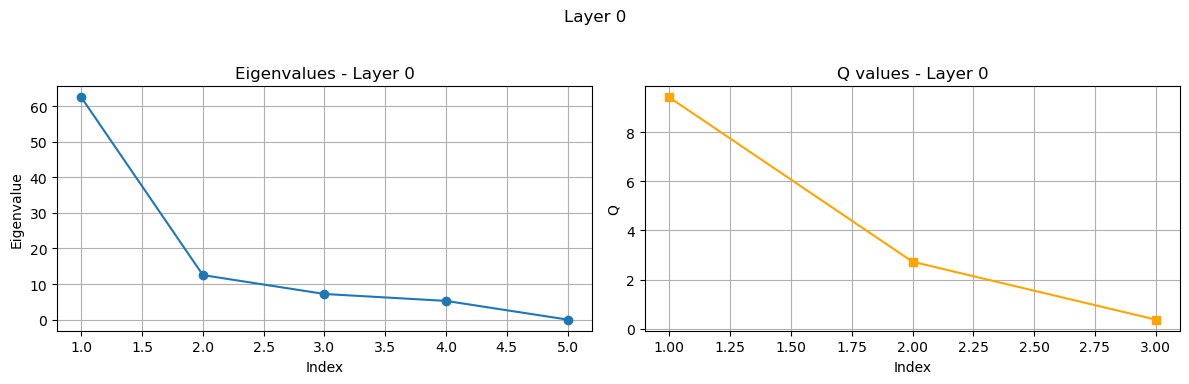

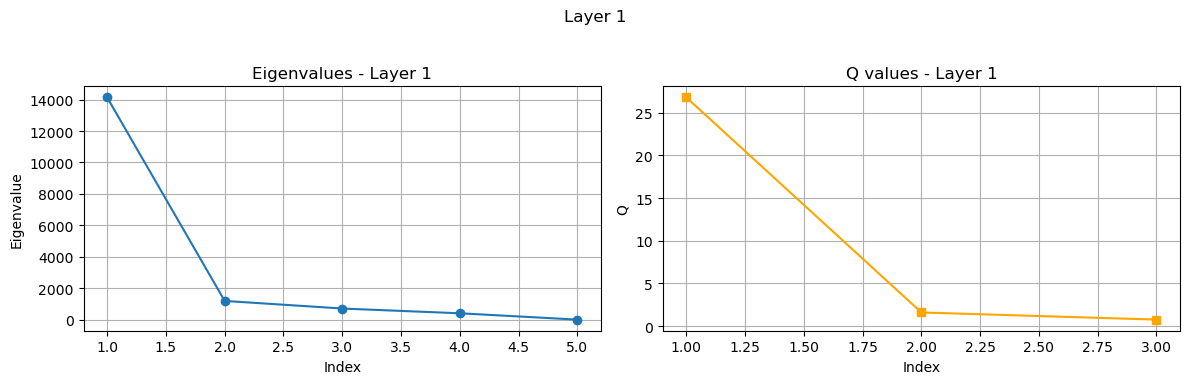

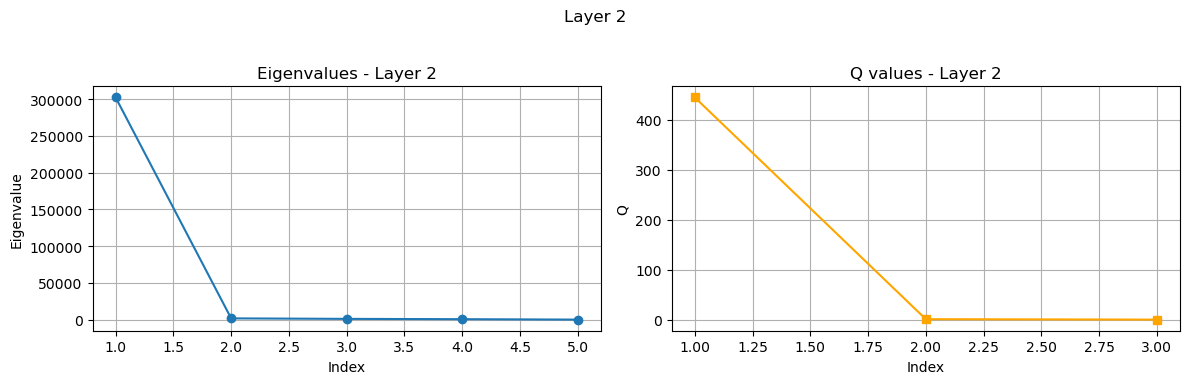

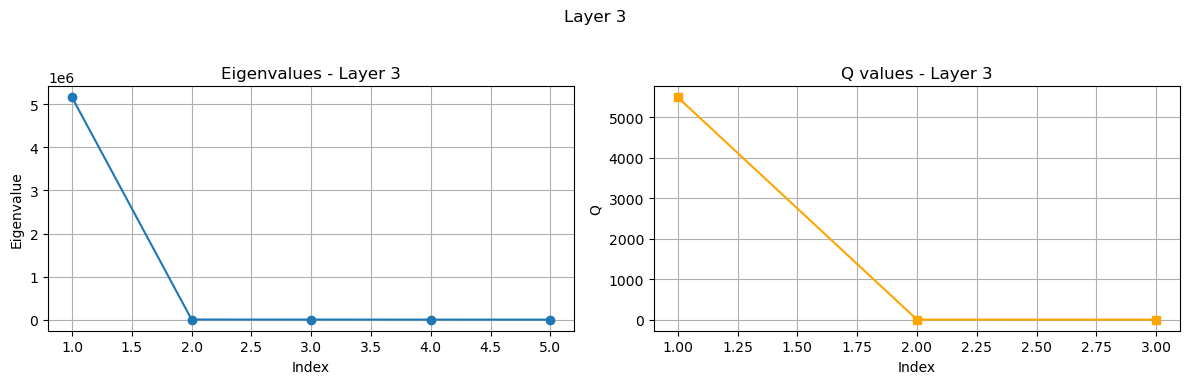

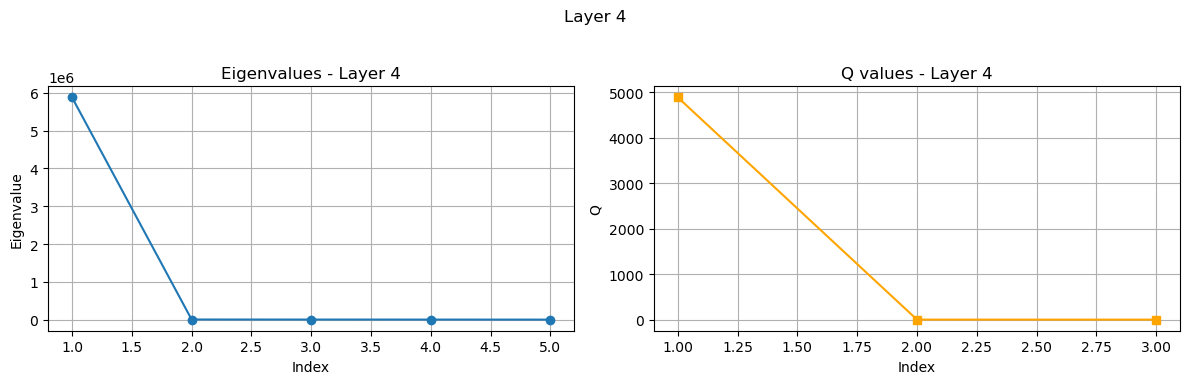

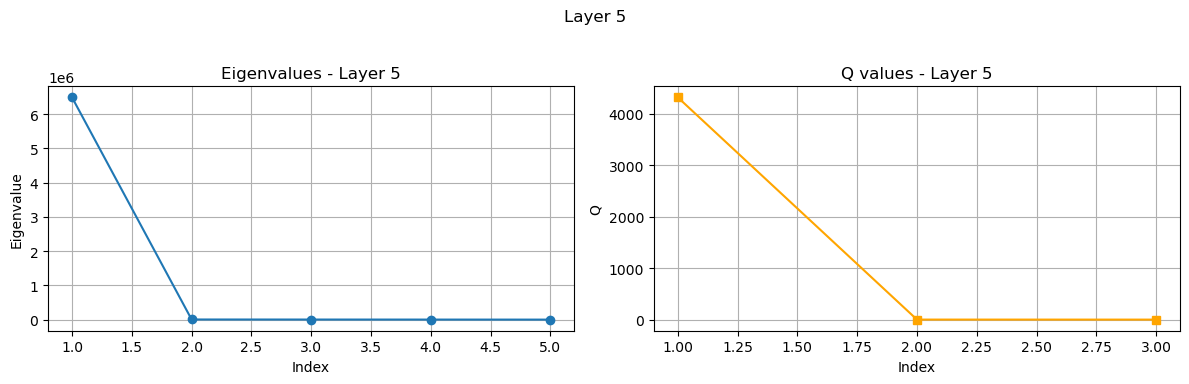

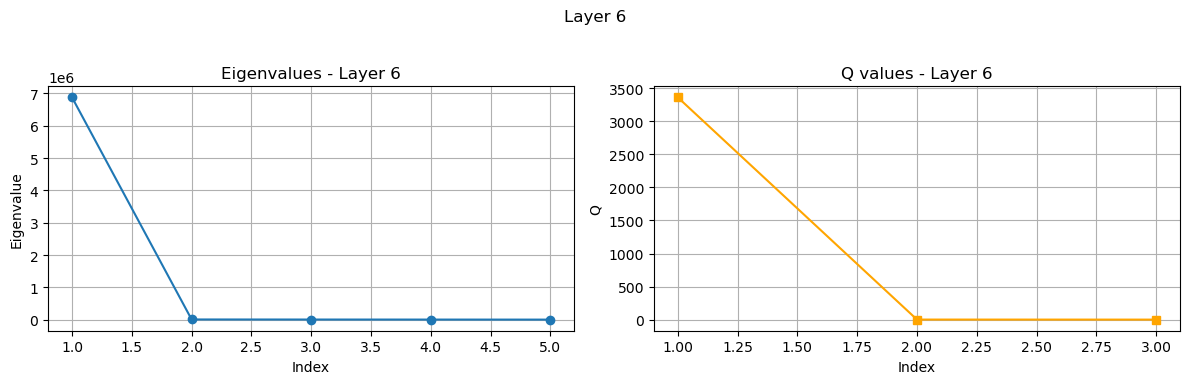

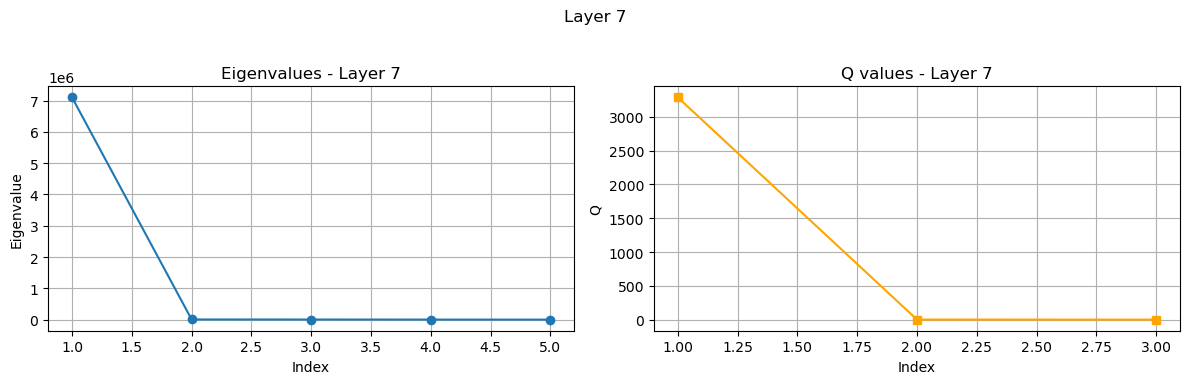

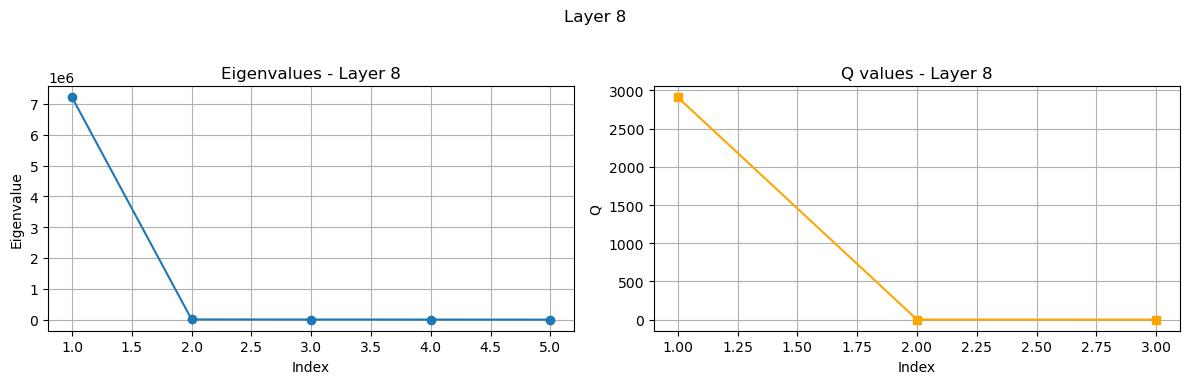

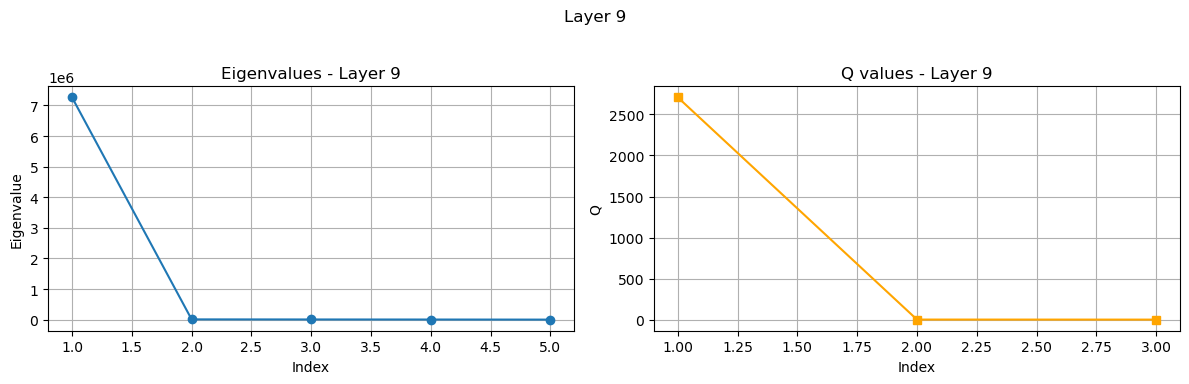

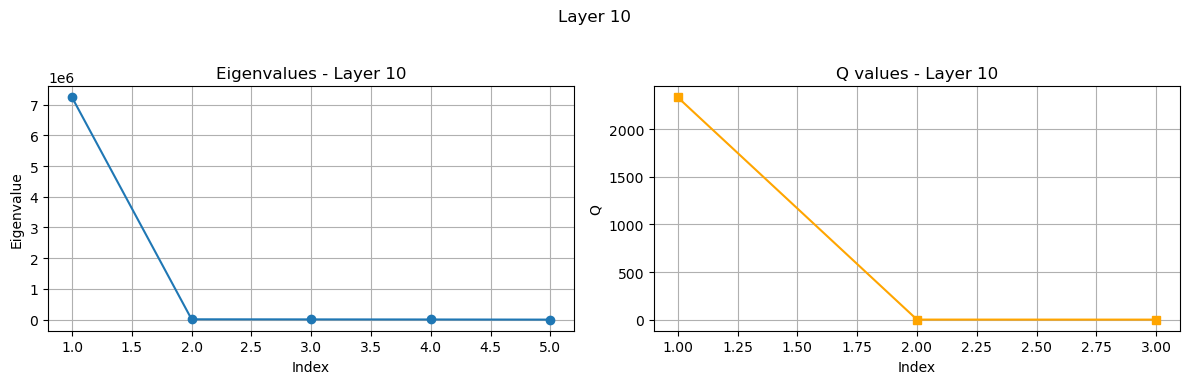

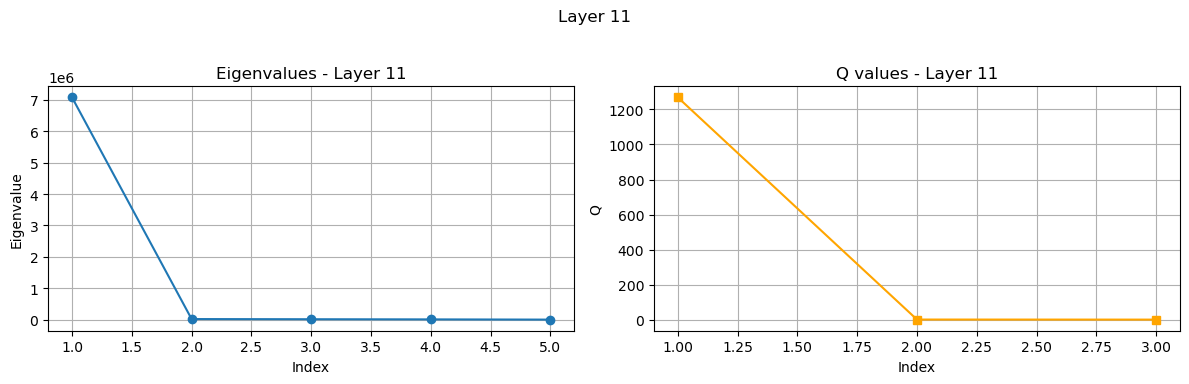

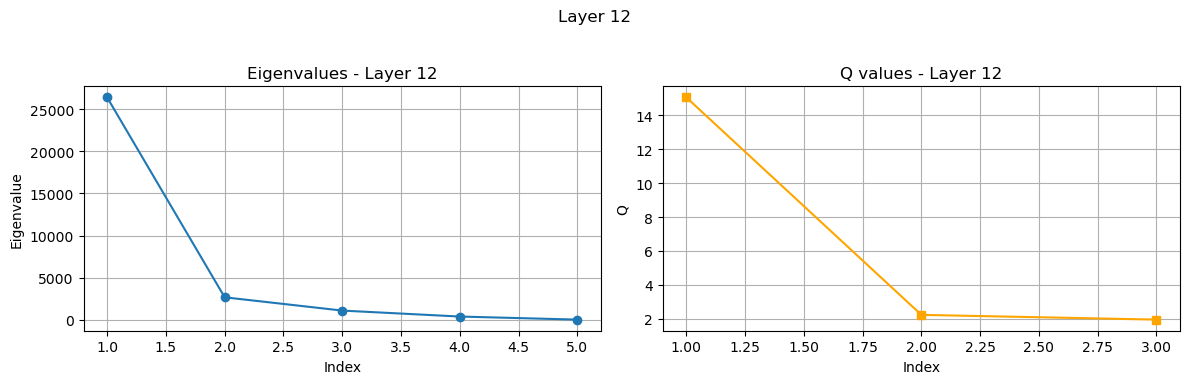

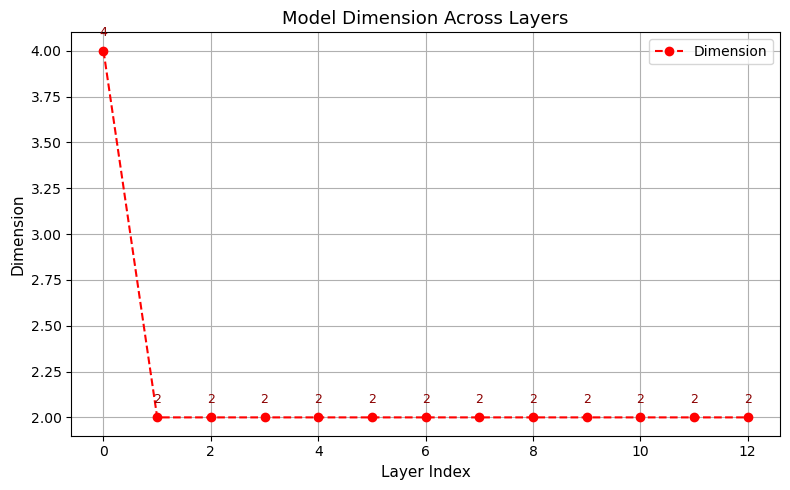

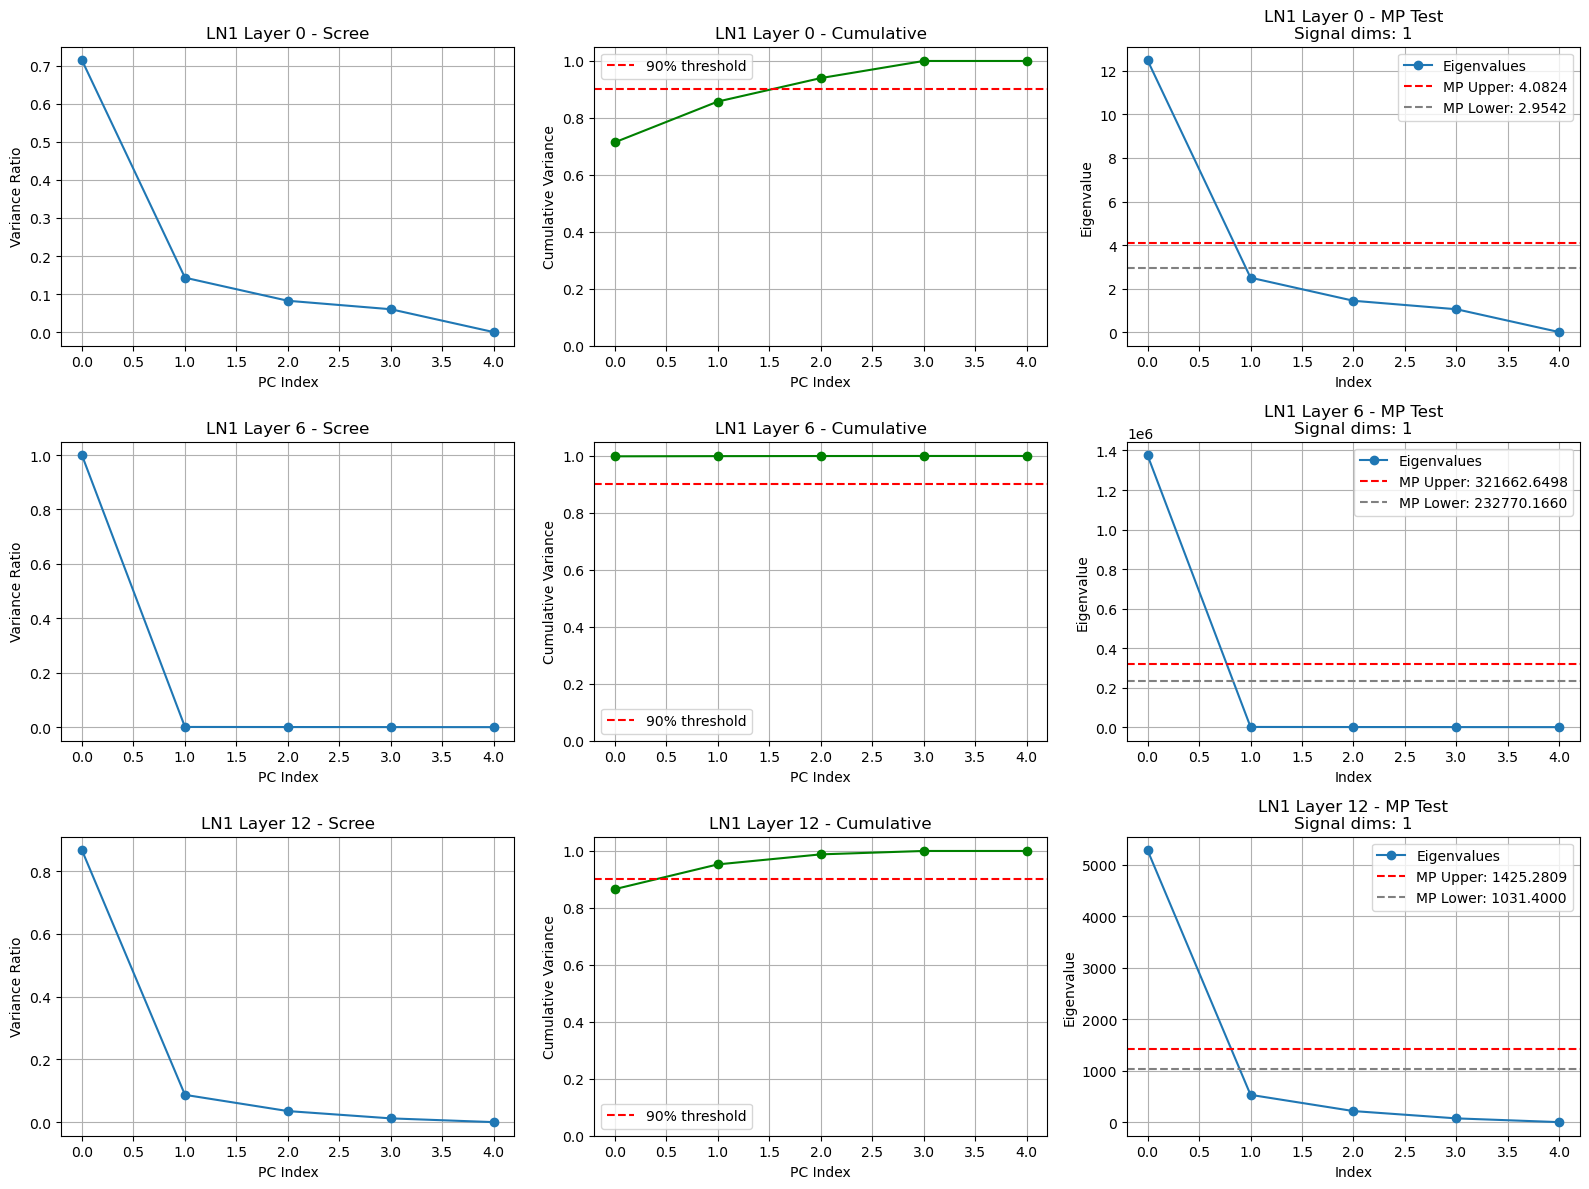

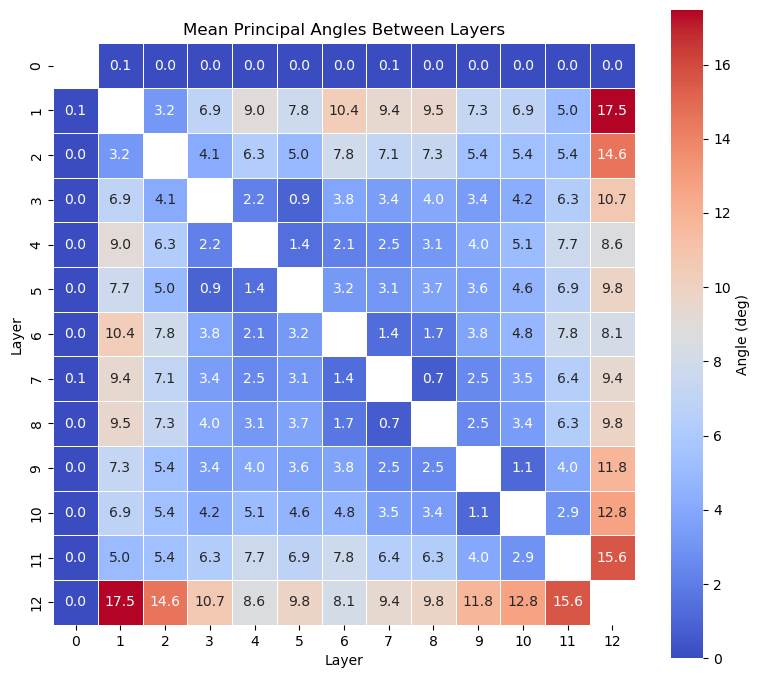

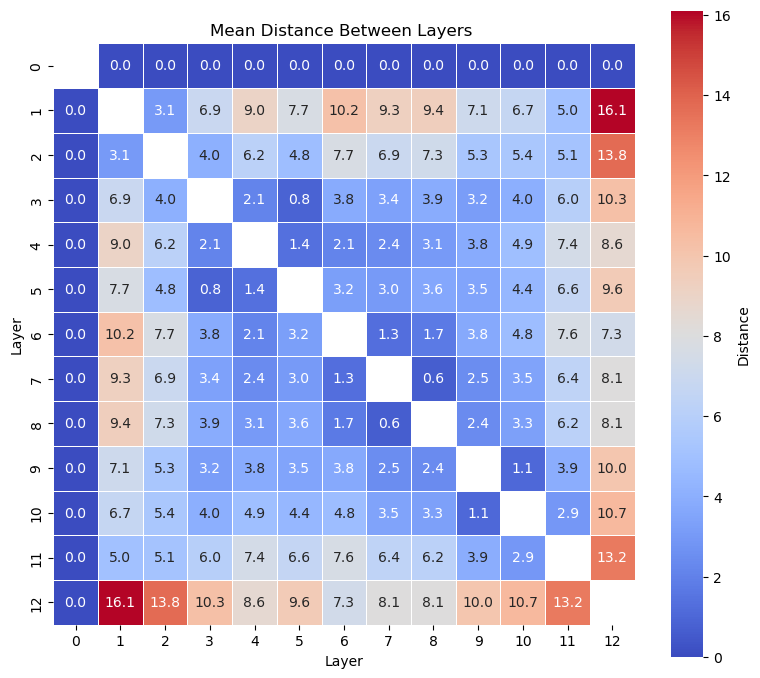

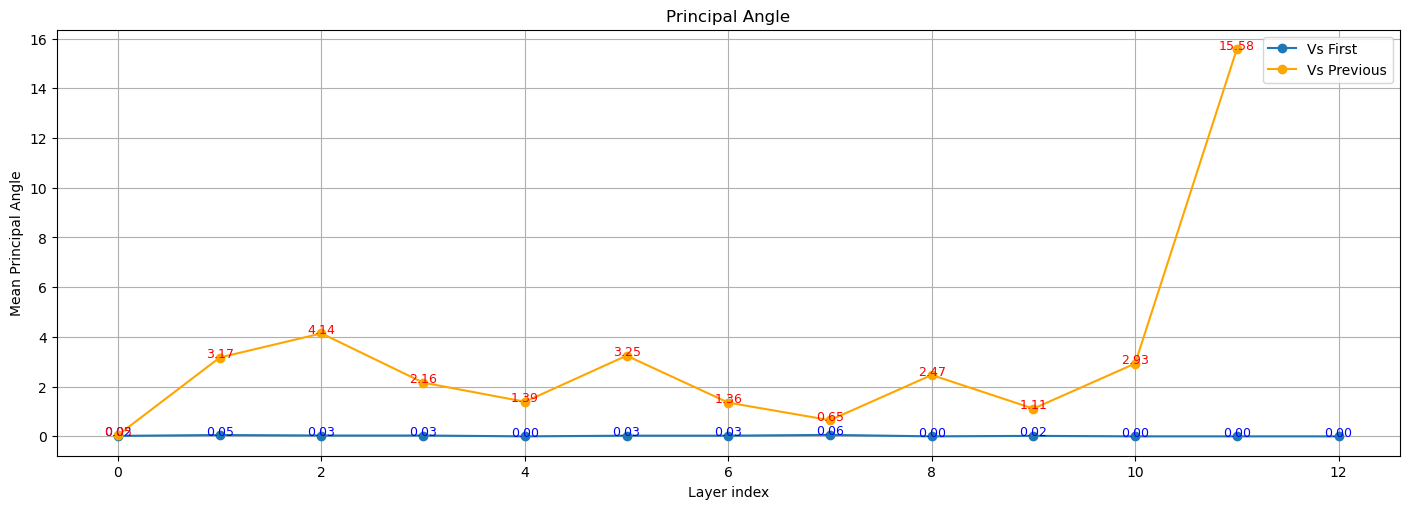

MWMWMWMWMMWMWMWMMWMWMWMWMWMMWMWM
ANALYZING prompt  medium
MWMWMWMWMMWMWMWMMWMWMWMWMWMMWMWM


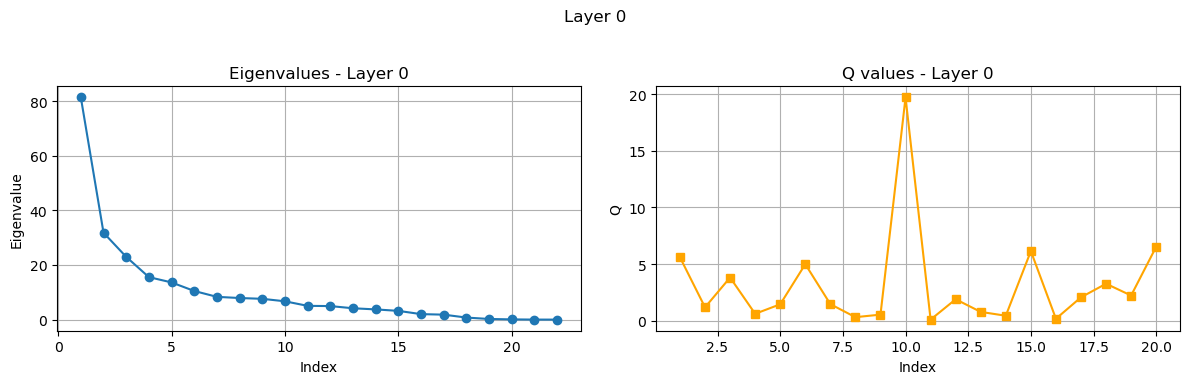

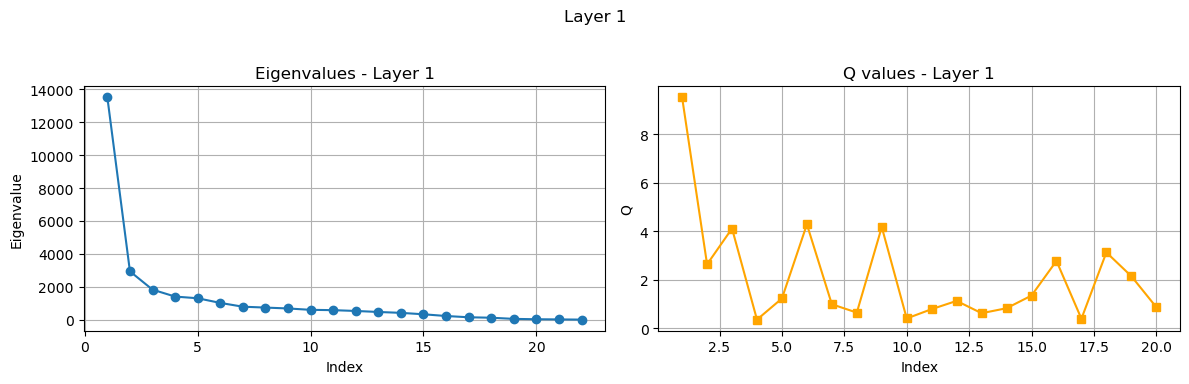

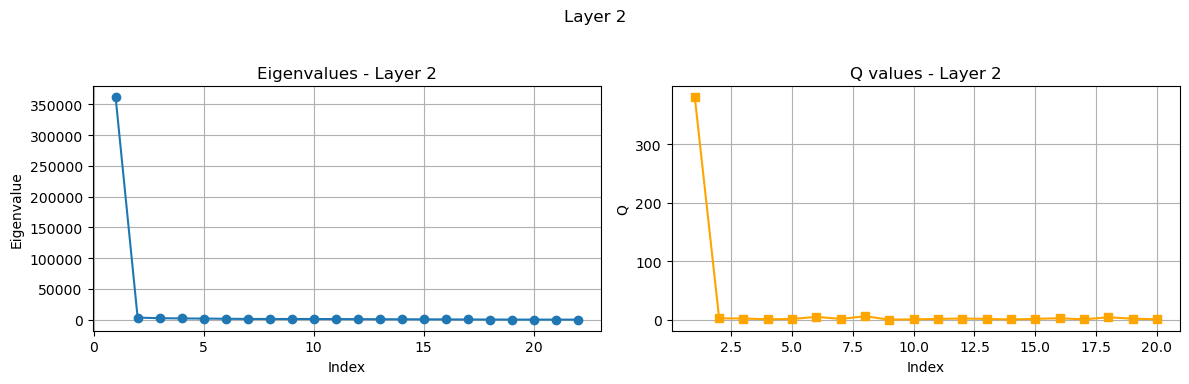

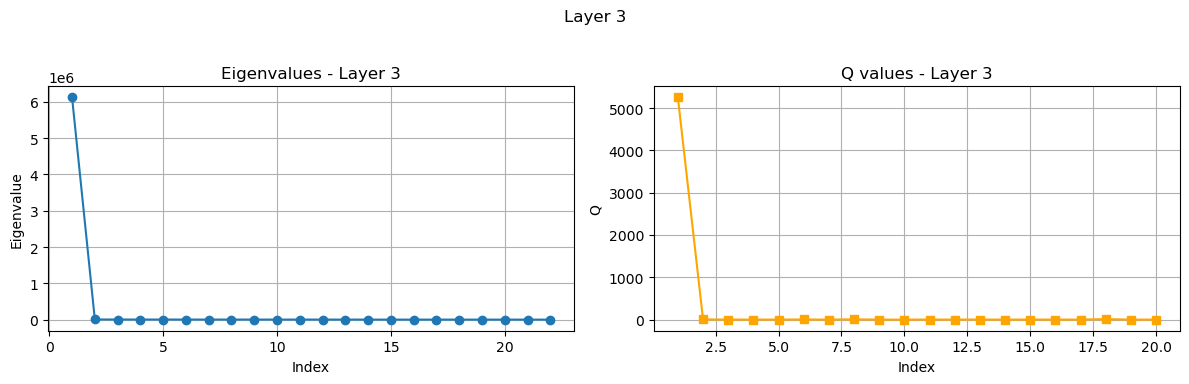

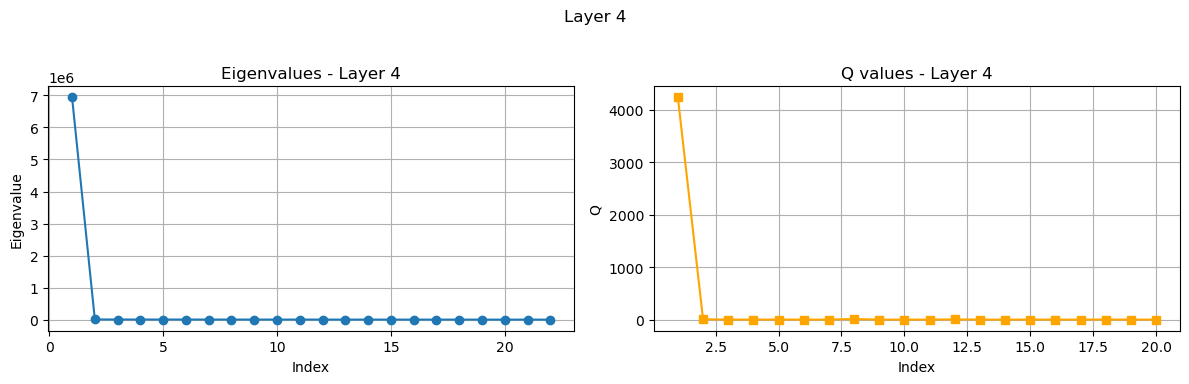

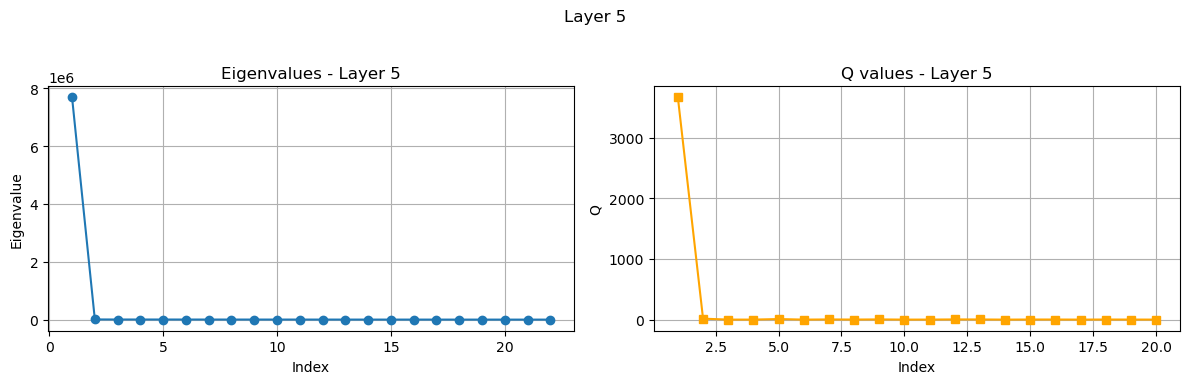

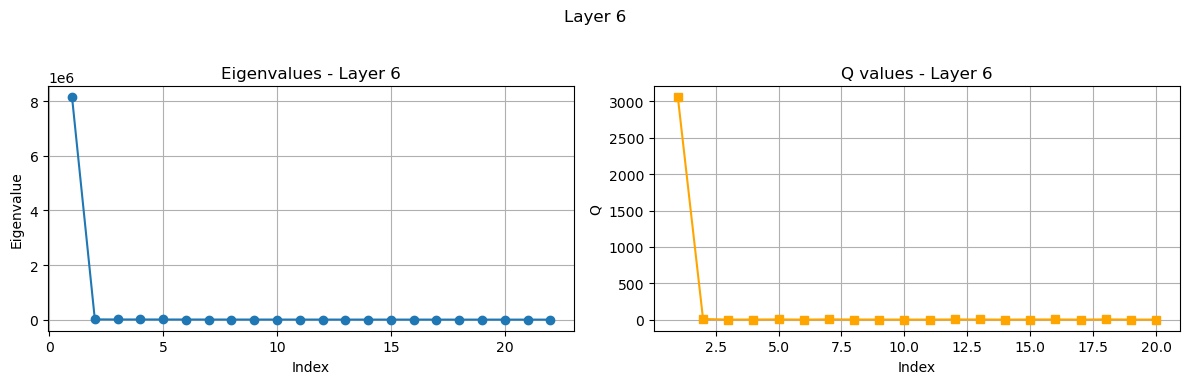

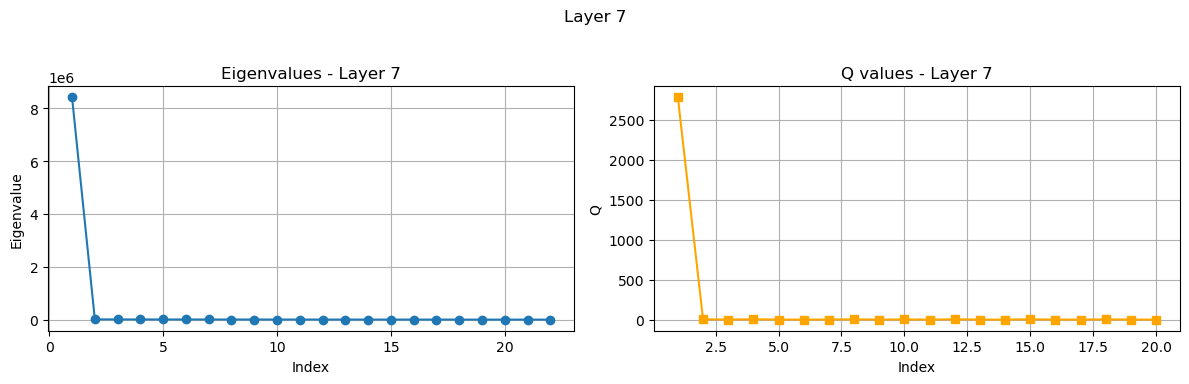

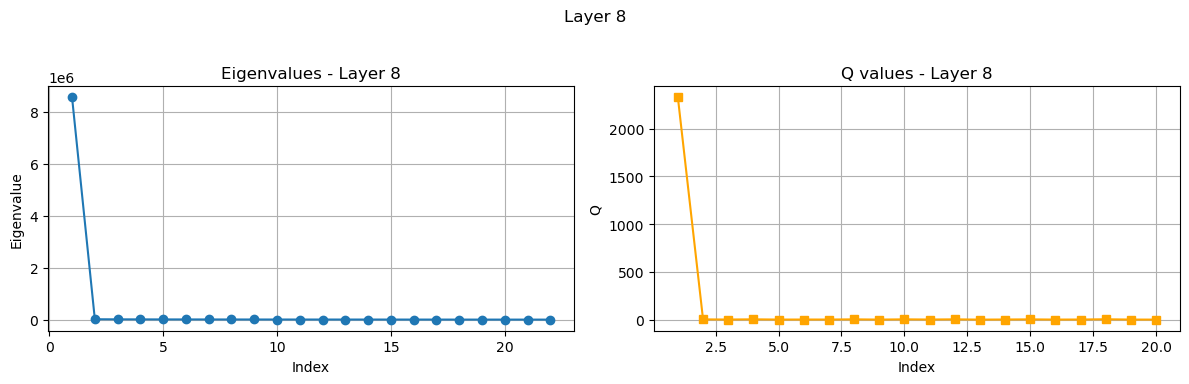

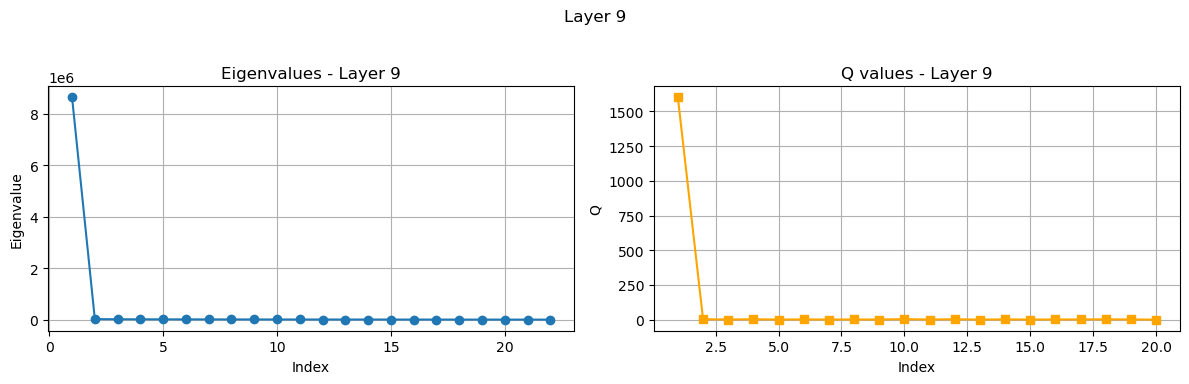

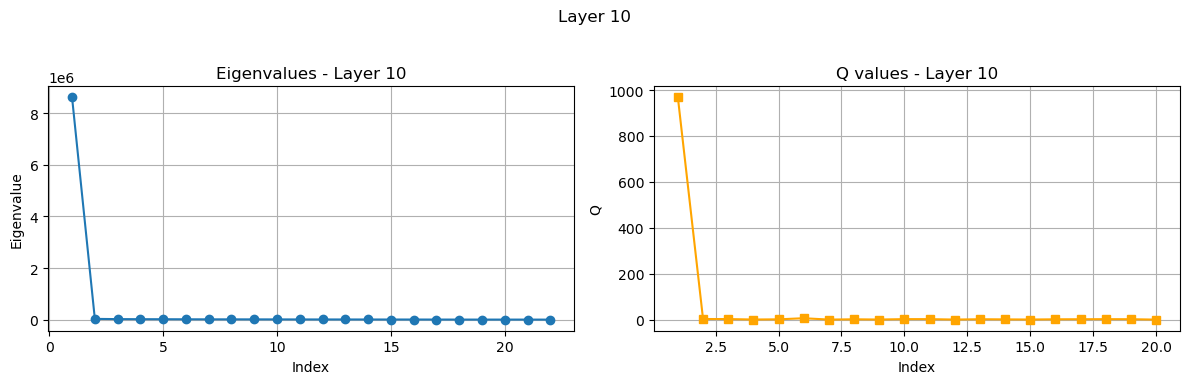

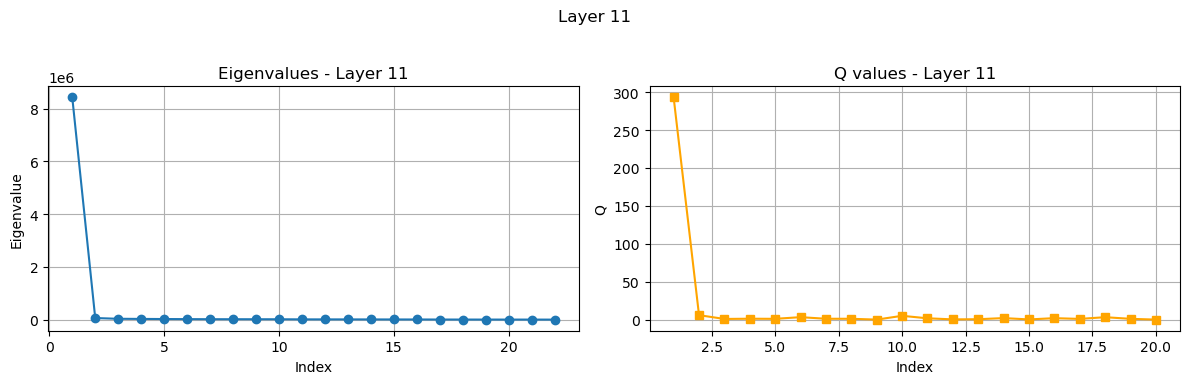

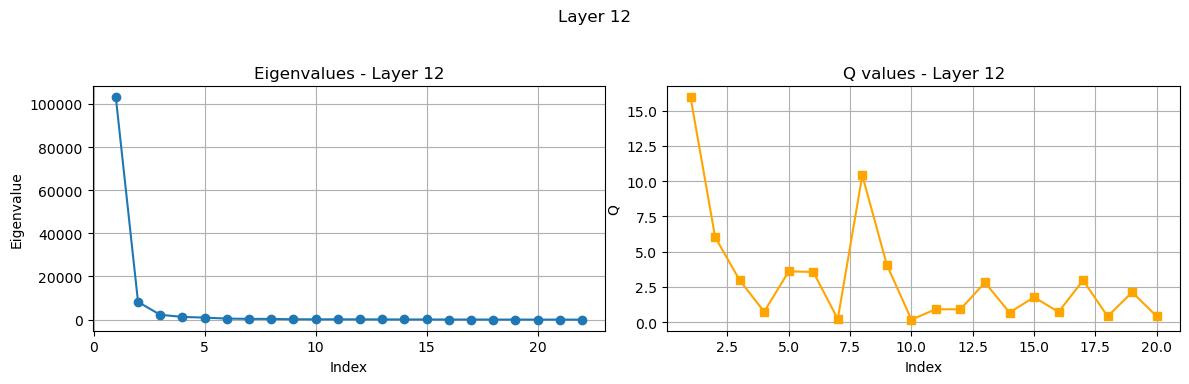

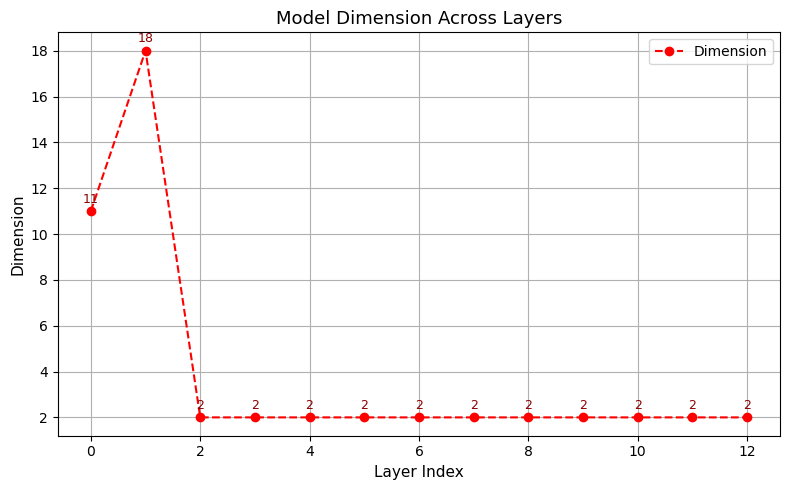

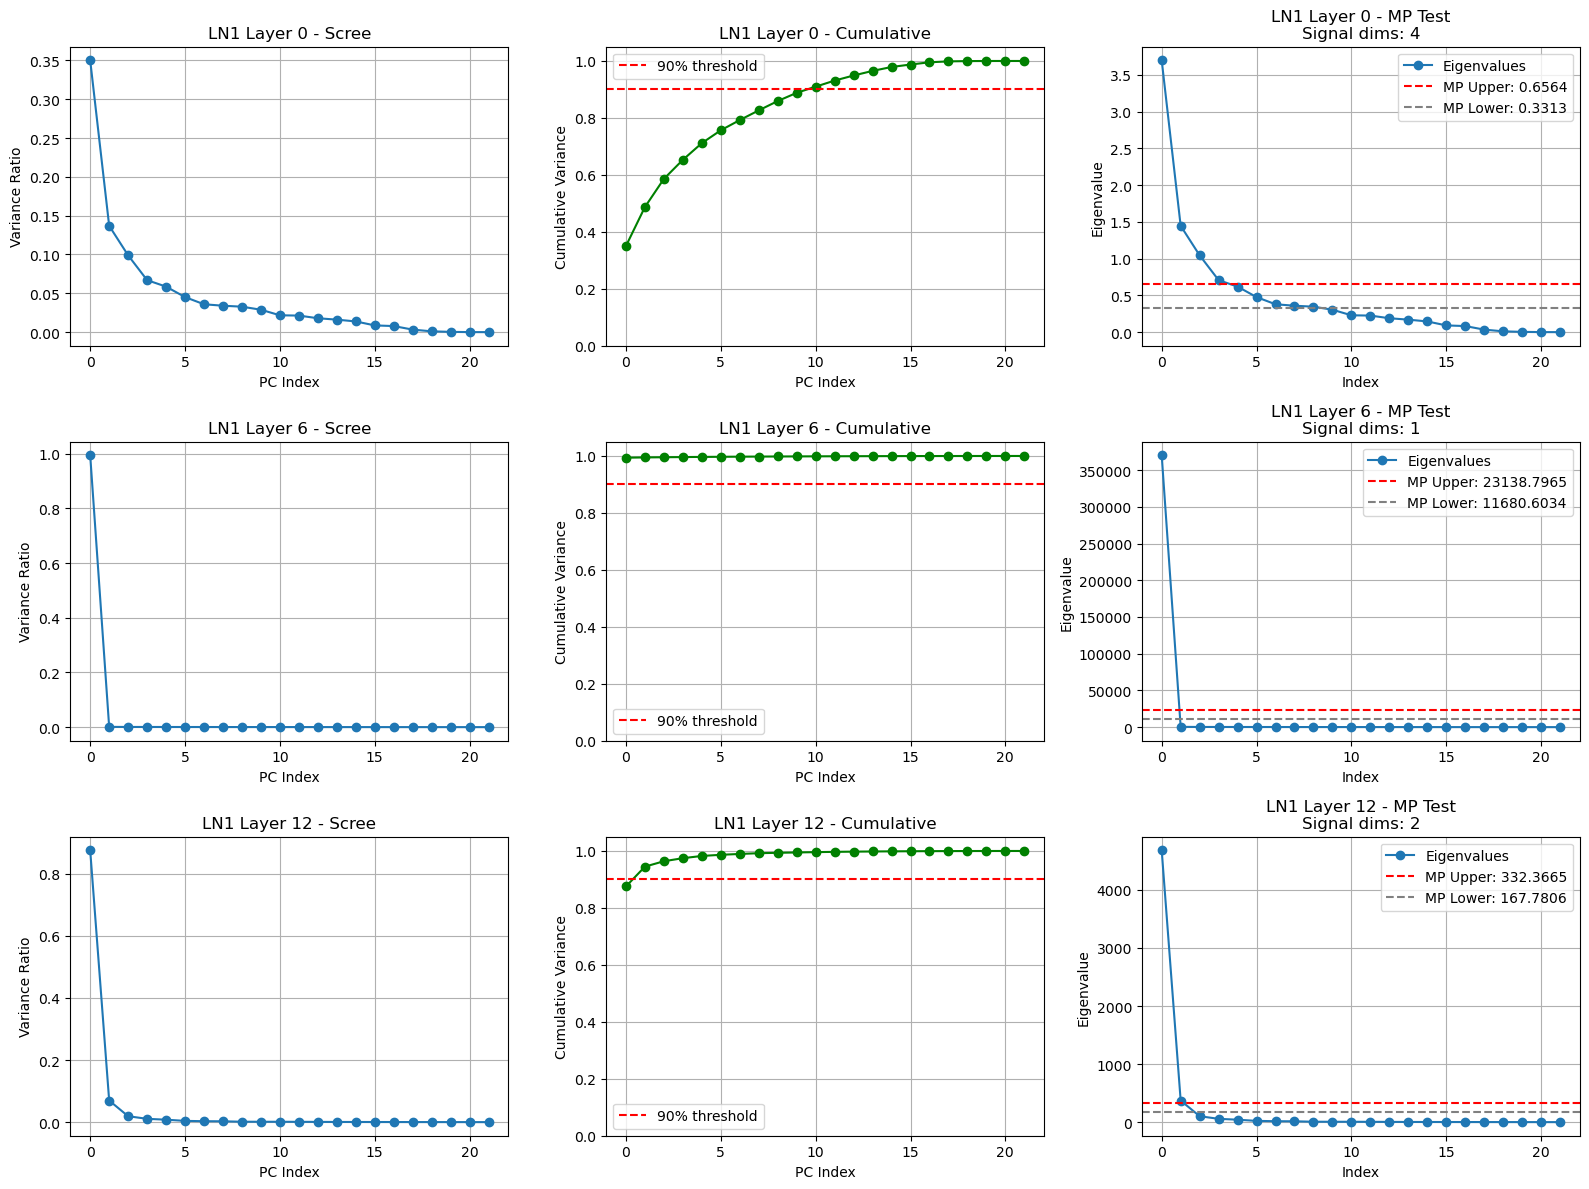

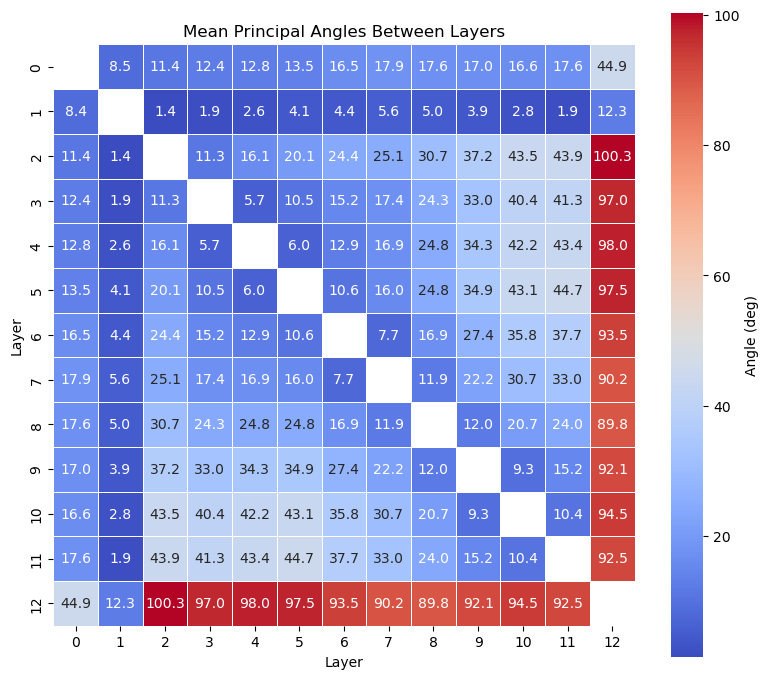

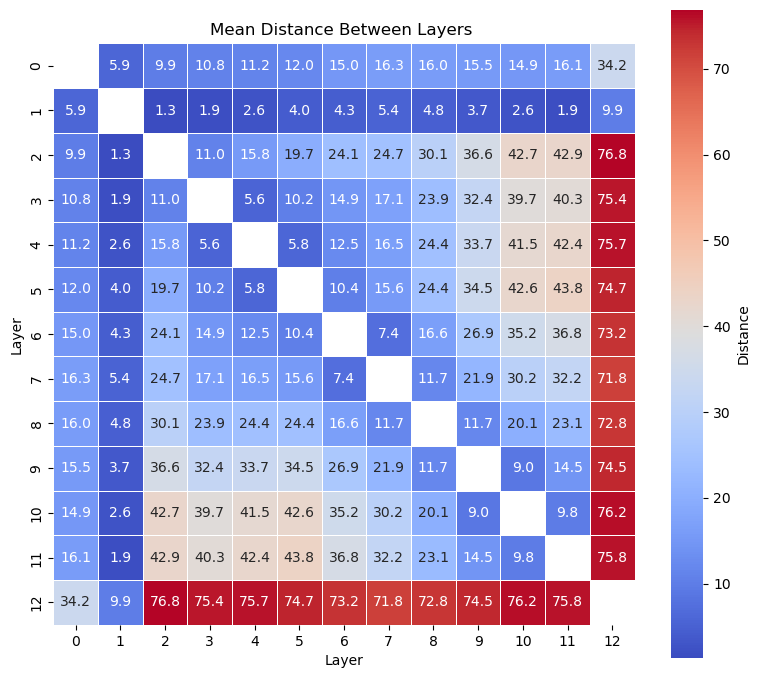

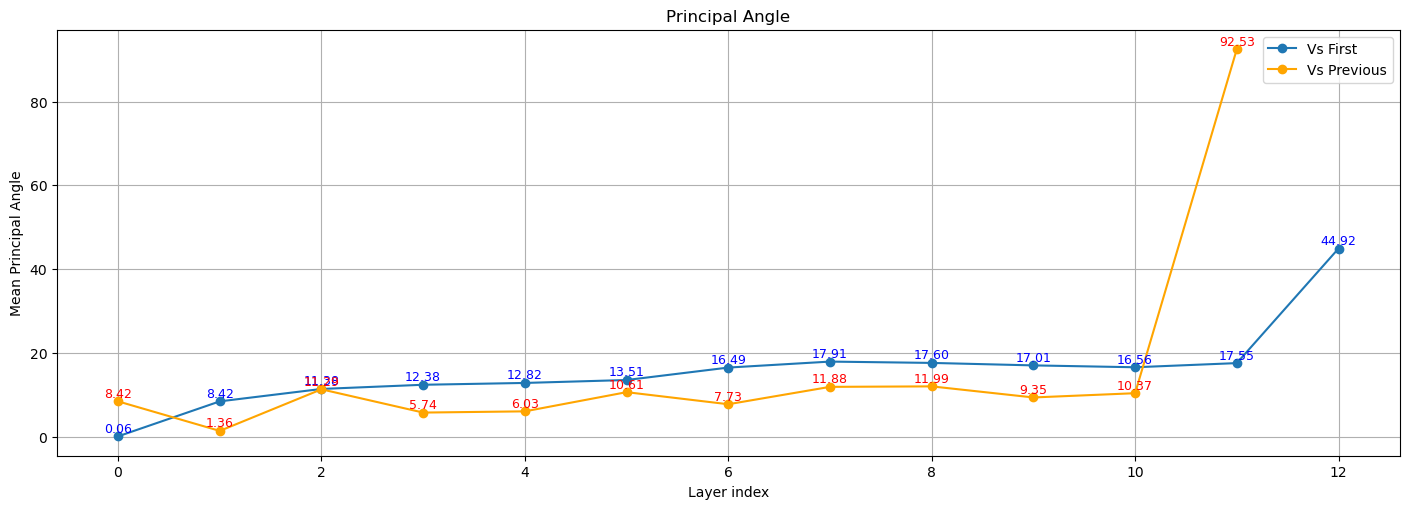

MWMWMWMWMMWMWMWMMWMWMWMWMWMMWMWM
ANALYZING prompt  long
MWMWMWMWMMWMWMWMMWMWMWMWMWMMWMWM


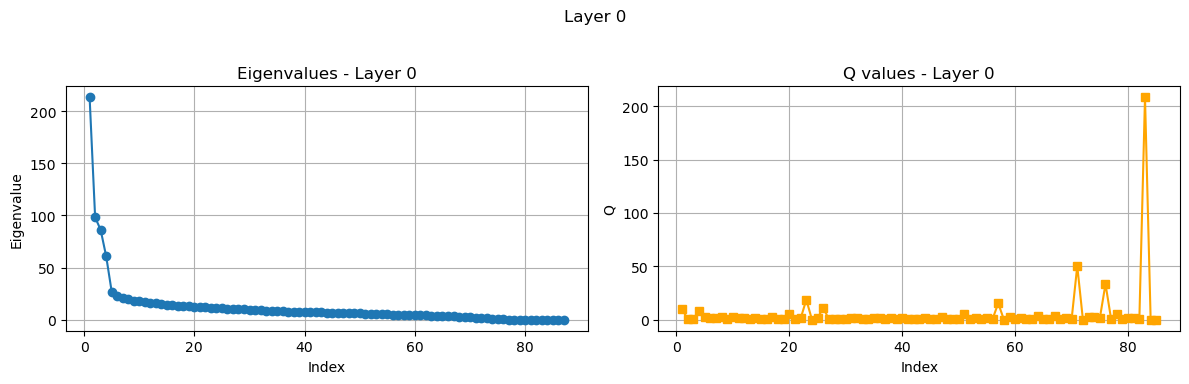

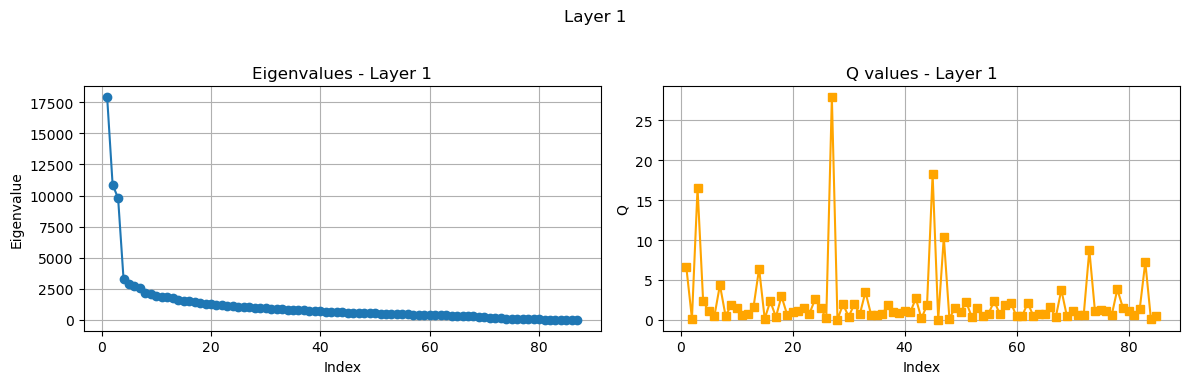

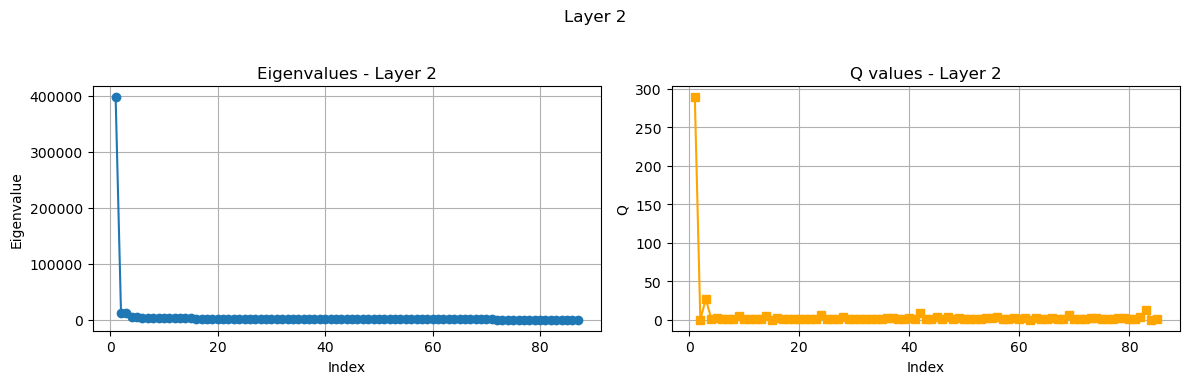

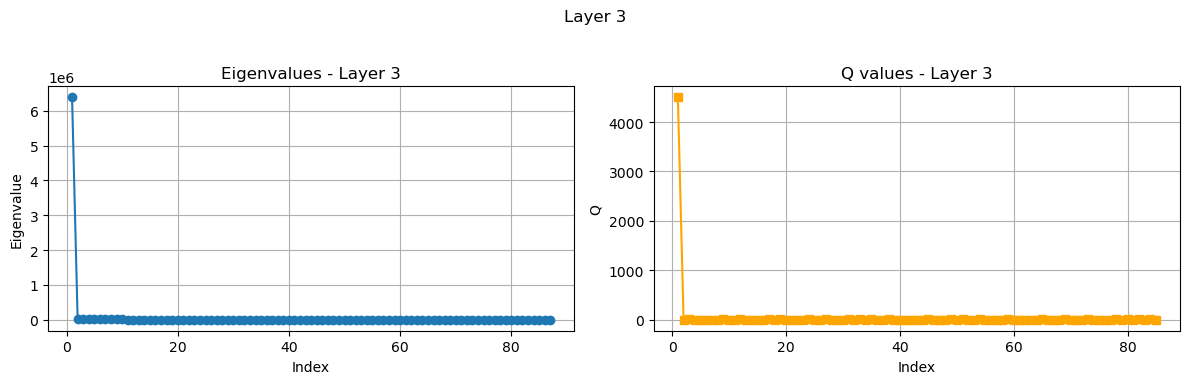

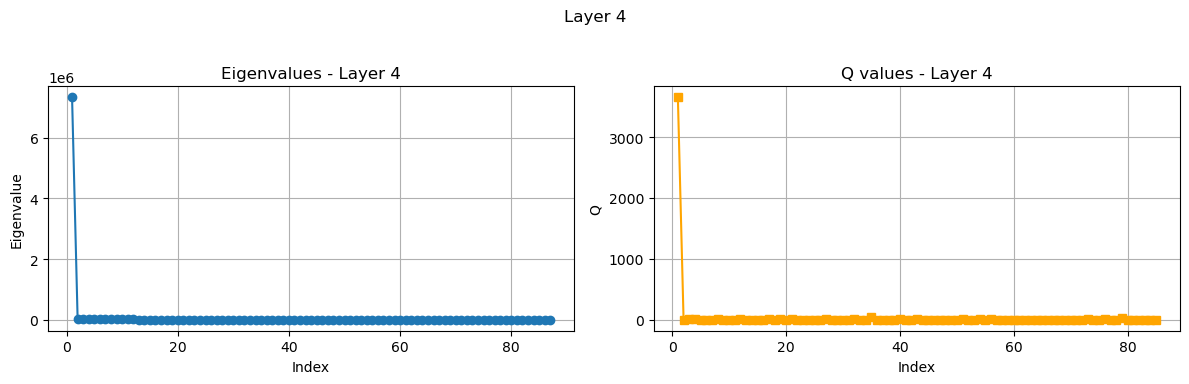

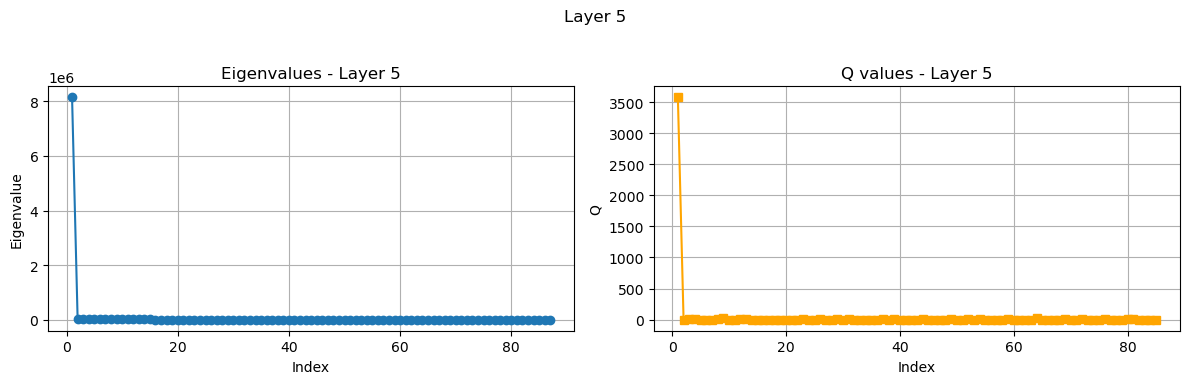

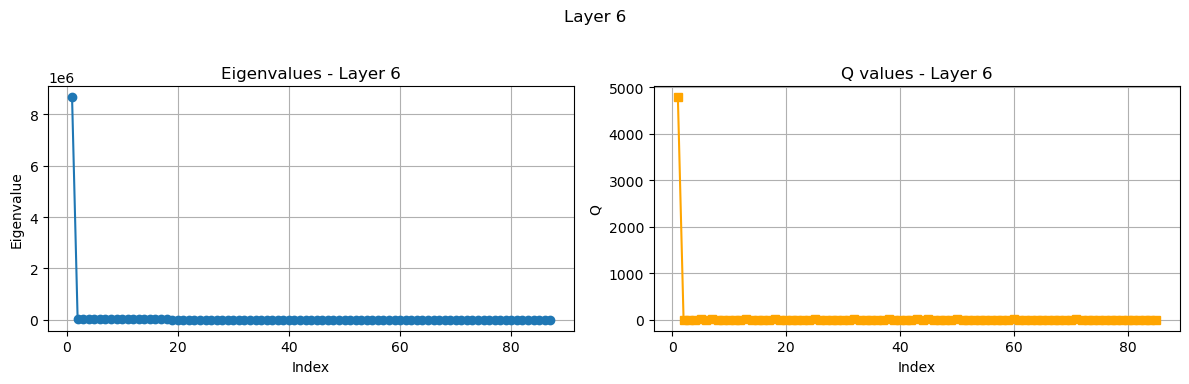

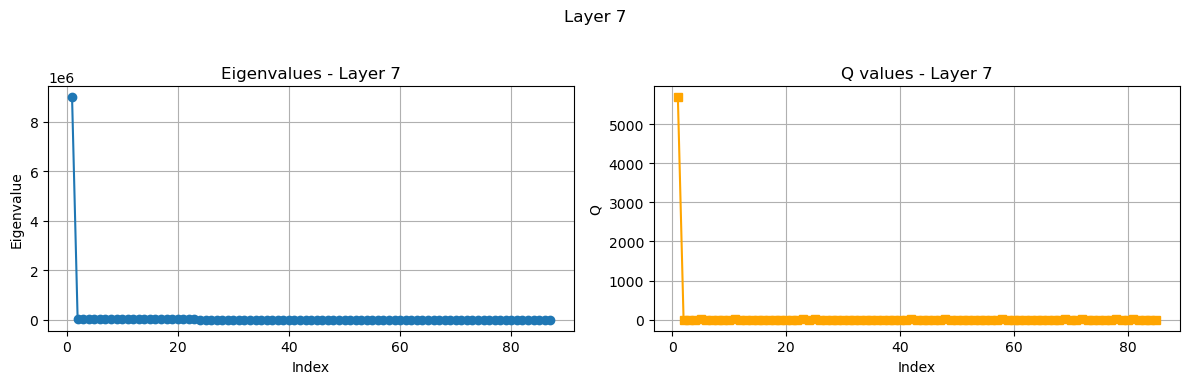

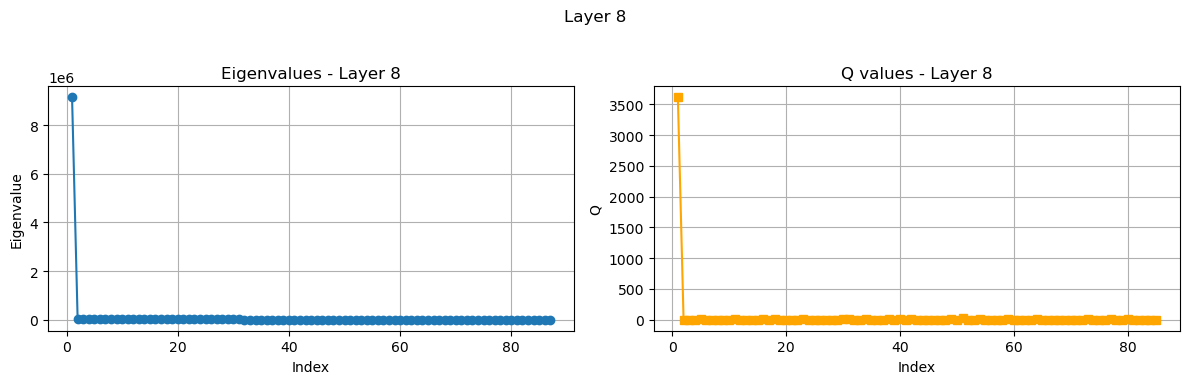

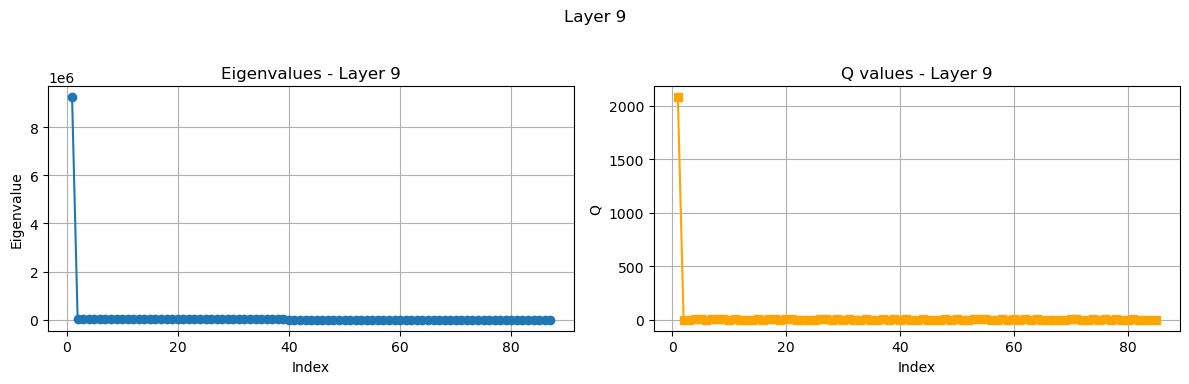

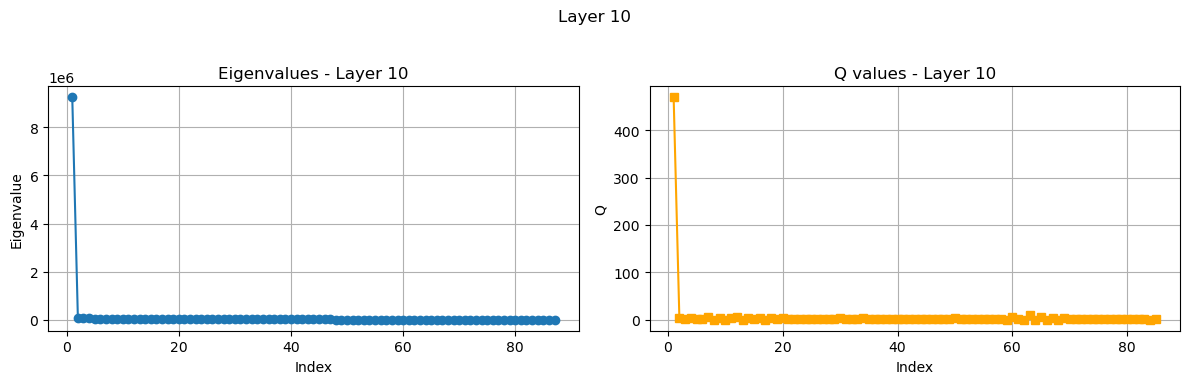

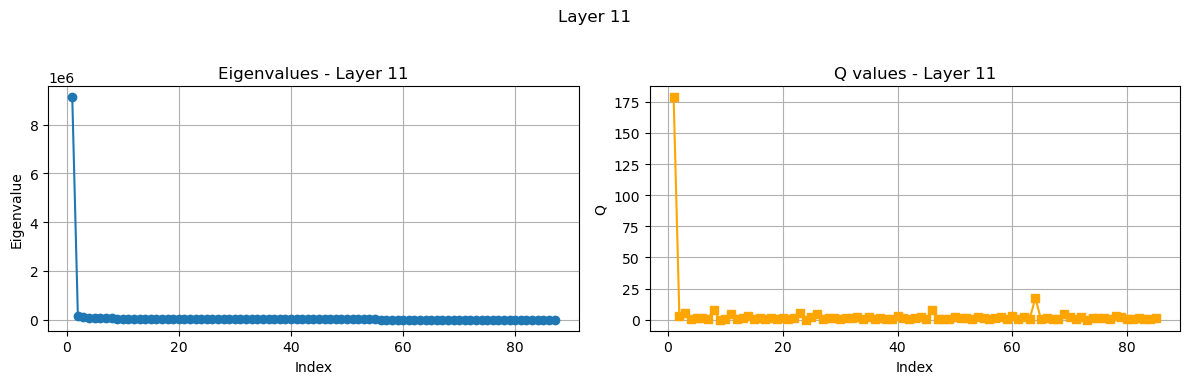

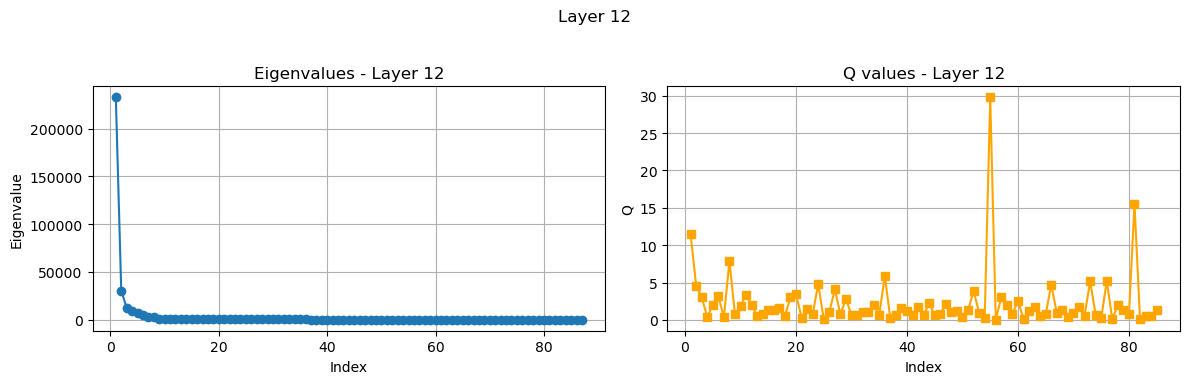

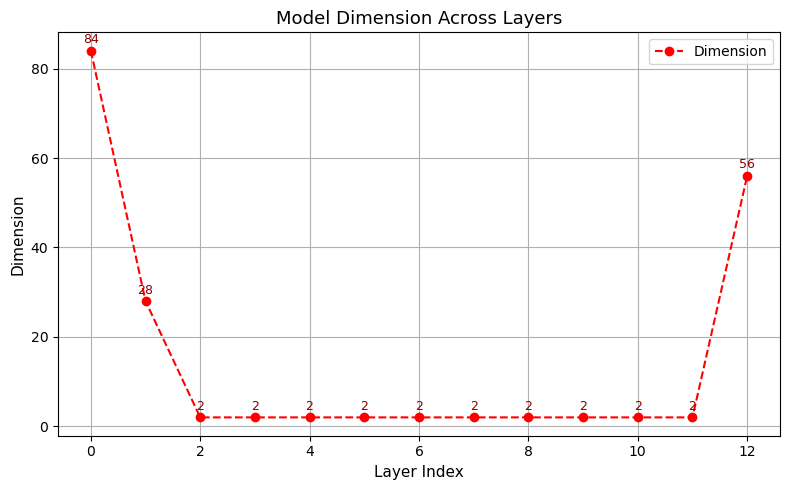

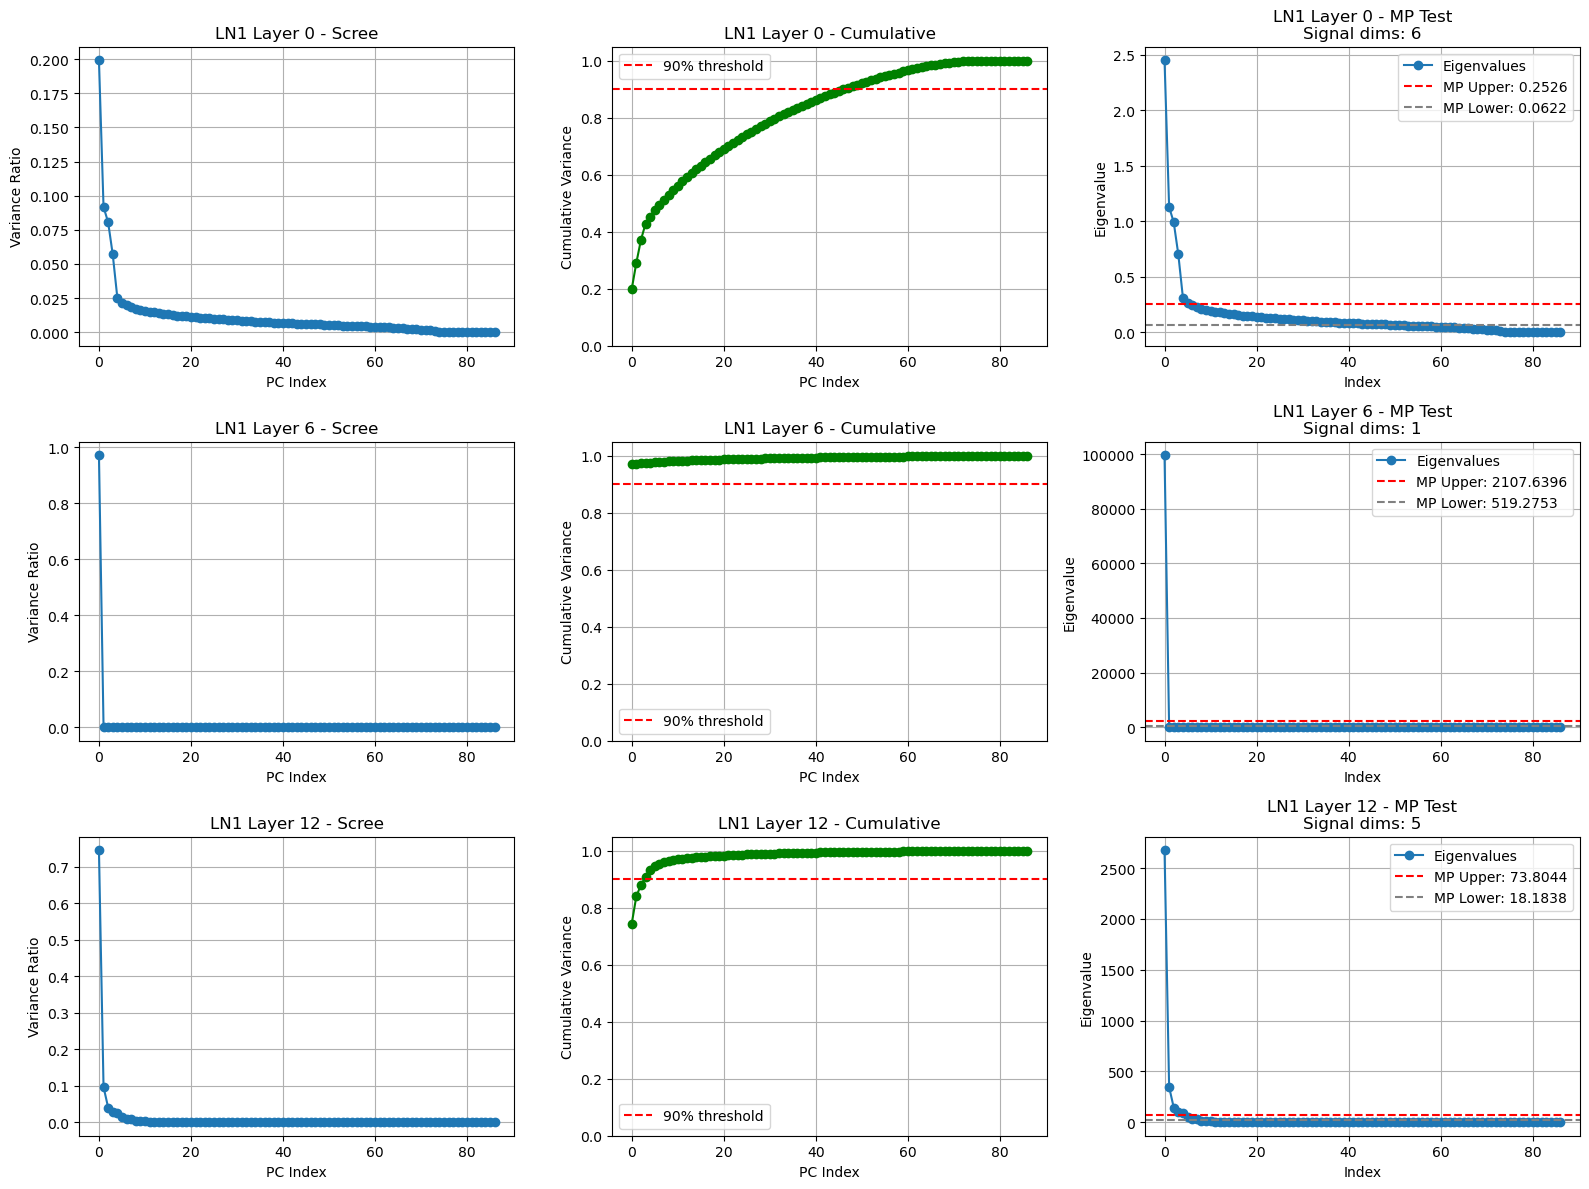

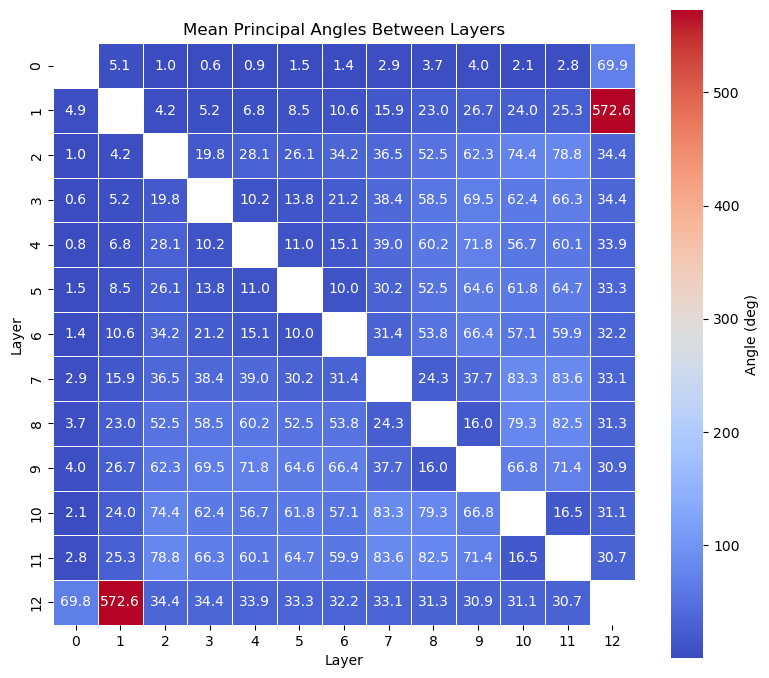

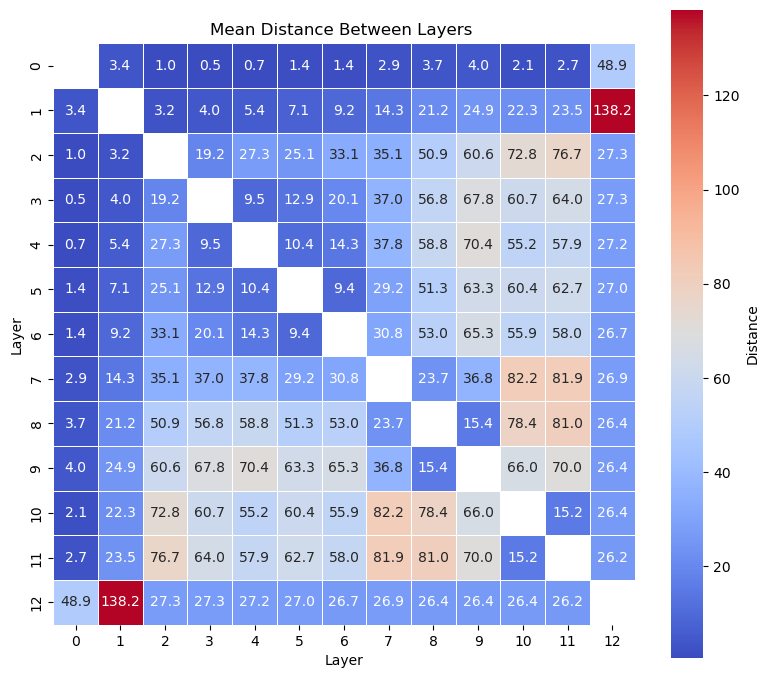

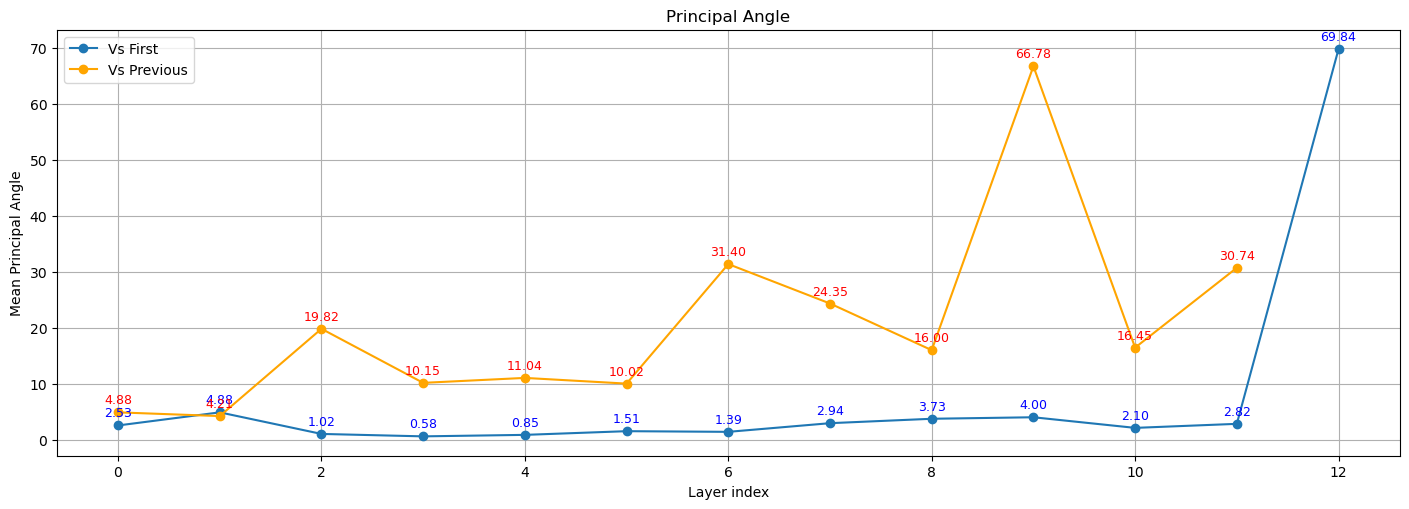

In [21]:

types=["short","medium", "long"      ]
##############  MAIN #################
all_angle=[]
for i, prompt in enumerate(prompt_type):
    
    print("MWMWMWMWMMWMWMWMMWMWMWMWMWMMWMWM")
    print("ANALYZING prompt ", types[i])
    print("MWMWMWMWMMWMWMWMMWMWMWMWMWMMWMWM")

   
    
    pAngle_all, dist_all, Q_tot = compute_P_angle(prompt)

    plot_principle_angle(pAngle_all,dist_all, Q_tot)



